In [1]:
%load_ext autoreload
%autoreload 2

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# Artisinal, small-batch, handmade modules
import classification_metrics

## Def describe

In [2]:
def describe(df, random=False):
    print(df.shape)
    print("--- First 5 entries ---")
    display(df.head())
    if random:
        print('--- Random subset ---')
        display(df.sample(5))

## Shared cell types

In [3]:
SHARED_CELLTYPES = [
    "Capillary",
    "Alveolar Epithelial Type 2",
    "B cell",
    "T cell",
    "Natural Killer T cell",
    "Macrophage",
    "Monocyte",
    "Dendritic",
    "Fibroblast",
    "Smooth Muscle and Myofibroblast",
]

## Broad to compartment

In [4]:
BROAD_TO_COMPARTMENT = pd.Series({
    "Capillary": "endothelial",
    "Artery": "endothelial",
    "Vein": "endothelial",
    "Alveolar Epithelial Type 2": "epithelial",
    "T cell": "lymphoid",
    "B cell": "lymphoid",
    "Natural Killer T cell": "lymphoid",
    "Natural Killer": "lymphoid",
    "Monocyte": "myeloid",
    "Macrophage": "myeloid",
    "Dendritic": "myeloid",
    "Neutrophil": "myeloid",
    "Fibroblast": "stromal",
    "Smooth Muscle and Myofibroblast": "stromal",
})
broad_to_compartment = BROAD_TO_COMPARTMENT[SHARED_CELLTYPES]
broad_to_compartment

Capillary                          endothelial
Alveolar Epithelial Type 2          epithelial
B cell                                lymphoid
T cell                                lymphoid
Natural Killer T cell                 lymphoid
Macrophage                             myeloid
Monocyte                               myeloid
Dendritic                              myeloid
Fibroblast                             stromal
Smooth Muscle and Myofibroblast        stromal
dtype: object

## file paths

In [5]:
sig_outdir_base = "/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures"

top_hit_suffix = os.path.join(
    "4--aggregated-results",
    "sourmash-search-results--top-hit.parquet",
)

self2self_parquet = os.path.join(
    sig_outdir_base, "0--mouse2mouse", "0--self2self-bootstrapped", top_hit_suffix
)

mouse2mouse_parquet = os.path.join(
    sig_outdir_base, "0--mouse2mouse", "1--mouse2mouse", top_hit_suffix
)

lemur_parquet = os.path.join(sig_outdir_base, "4--test-lemur", top_hit_suffix)

bat_parquet = os.path.join(sig_outdir_base, "3--test-bat", top_hit_suffix)
human_parquet = os.path.join(sig_outdir_base, "2--test-human", top_hit_suffix)

top_hit_paths = {
#     "self": self2self_parquet,
    "mouse": mouse2mouse_parquet,
    "lemur": lemur_parquet,
    "bat": bat_parquet,
    "human": human_parquet,
}

## Assign figure folder

In [6]:
figure_folder = (
    "/home/olga/googledrive/ImmuneEvolution/figures/kmermaid_classification_metrics"
)


## Function To get colormap per alpahbet

In [ ]:
def get_cmap_color(keys):
    if 'protein' in keys:
        return "Oranges"
    if 'DNA' in keys:
        return "Blues"
    if 'dayhoff' in keys:
        return "Greens"


# Read in classification data

In [7]:
dfs = []
for species, parquet in top_hit_paths.items():
    try:
        df = pd.read_parquet(parquet)
    except FileNotFoundError:
        print(f"Could not find parquet for {species}")
        continue

    print(f"Species: {species}")
    describe(df)

    df["species"] = species
    df = df.query(
        "groundtruth_celltype in @SHARED_CELLTYPES "
        "and predicted_celltype in @SHARED_CELLTYPES"
    )
    df.index.name = "query_cell_id"
    dfs.append(df)
predicted_cells = pd.concat(dfs, ignore_index=False)

databases_to_choose = "min-10-percent-shared-kmers-remove-common-kmers"  , 'min-5-percent-shared-kmers-remove-common-kmers'

# Only use database with common k-mers removed because without that, no AT2 cells are predicted!
# predicted_cells = predicted_cells.query(
#     'database_type == "min-10-percent-shared-kmers-remove-common-kmers" '
#     'and search_method == "similarity_abundance"'
# )
# predicted_cells = predicted_cells.query('database_type == "remove_common"')
# predicted_cells = predicted_cells.loc[predicted_cells.database_type.isin(databases_to_choose) ]
predicted_cells.groundtruth_celltype = (
    predicted_cells.groundtruth_celltype.cat.remove_unused_categories()
)
# predicted_cells.predicted_celltype = predicted_cells.predicted_celltype.cat.remove_unused_categories()
describe(predicted_cells)

Species: mouse
(65940, 24)
--- First 5 entries ---


,similarity,mouse1_broad_group,search_method,database_type,sketch_id,mol_or_alpha,alphabet,ksize,sketch_style,sketch_value,...,mouse2_compartment_group,database_method,mouse2_human_readable,broad_group_matches,broad_group_matches_string,alpha_ksize,alpha_match,mouse2_match,groundtruth_celltype,predicted_celltype
mouse2_cell_id,,,,,,,,,,,,,,,,,,,,,
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.296154,Monocyte,containment,min-10-percent-shared-kmers,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,...,lymphoid,min-10-percent-shared-kmers: containment,male:female,False,different celltype,"DNA, k:21","DNA, different celltype","male:female, different celltype",T cell,Monocyte
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.271510,Monocyte,containment,min-10-percent-shared-kmers,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,...,lymphoid,min-10-percent-shared-kmers: containment,male:female,False,different celltype,"dayhoff, k:51","dayhoff, different celltype","male:female, different celltype",T cell,Monocyte
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.296568,Monocyte,containment,min-10-percent-shared-kmers,alphabet-protein__ksize-30__scaled-10,alphabet,protein,30,scaled,10,...,lymphoid,min-10-percent-shared-kmers: containment,male:female,False,different celltype,"protein, k:30","protein, different celltype","male:female, different celltype",T cell,Monocyte
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.507136,T cell,similarity_abundance,min-10-percent-shared-kmers,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,...,lymphoid,min-10-percent-shared-kmers: similarity_abundance,male:female,True,same celltype,"DNA, k:21","DNA, same celltype","male:female, same celltype",T cell,T cell
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.537653,T cell,similarity_abundance,min-10-percent-shared-kmers,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,...,lymphoid,min-10-percent-shared-kmers: similarity_abundance,male:female,True,same celltype,"dayhoff, k:51","dayhoff, same celltype","male:female, same celltype",T cell,T cell


Species: lemur
(147236, 17)
--- First 5 entries ---


,similarity,mouse_broad_group,search_method,sketch_id,mol_or_alpha,alphabet,ksize,sketch_style,sketch_value,lemur_channel,lemur_cell_ontology_class,lemur_narrow_group,lemur_broad_group,lemur_compartment_group,database_type,groundtruth_celltype,predicted_celltype
lemur_cell_id,,,,,,,,,,,,,,,,,
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG,0.049508,Dendritic,containment,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,ANTOINE_LUNG_CD31,macrophage,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Dendritic
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG,0.114944,Dendritic,containment,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,ANTOINE_LUNG_CD31,macrophage,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Dendritic
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG,0.110182,Dendritic,containment,alphabet-protein__ksize-30__scaled-10,alphabet,protein,30,scaled,10,ANTOINE_LUNG_CD31,macrophage,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Dendritic
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG,0.081077,Macrophage,similarity_abundance,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,ANTOINE_LUNG_CD31,macrophage,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Macrophage
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG,0.090060,Macrophage,similarity_abundance,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,ANTOINE_LUNG_CD31,macrophage,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Macrophage


Species: bat
(216998, 17)
--- First 5 entries ---


,similarity,mouse_broad_group,search_method,sketch_id,mol_or_alpha,alphabet,ksize,sketch_style,sketch_value,bat_channel,bat_cell_ontology_class,bat_narrow_group,bat_broad_group,bat_compartment_group,database_type,groundtruth_celltype,predicted_celltype
bat_cell_id,,,,,,,,,,,,,,,,,
bat2-LU__AAACCTGAGGTACTCT,0.021308,Dendritic,containment,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,bat2-LU,nan,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Dendritic
bat2-LU__AAACCTGAGGTACTCT,0.056749,Dendritic,containment,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,bat2-LU,nan,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Dendritic
bat2-LU__AAACCTGAGGTACTCT,0.064116,Dendritic,containment,alphabet-protein__ksize-30__scaled-10,alphabet,protein,30,scaled,10,bat2-LU,nan,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Dendritic
bat2-LU__AAACCTGAGGTACTCT,0.060978,Macrophage,similarity_abundance,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,bat2-LU,nan,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Macrophage
bat2-LU__AAACCTGAGGTACTCT,0.030150,Dendritic,similarity_abundance,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,bat2-LU,nan,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Dendritic


Species: human
(424610, 17)
--- First 5 entries ---


,similarity,mouse_broad_group,search_method,sketch_id,mol_or_alpha,alphabet,ksize,sketch_style,sketch_value,human_channel,human_cell_ontology_class,human_narrow_group,human_broad_group,human_compartment_group,database_type,groundtruth_celltype,predicted_celltype
human_cell_id,,,,,,,,,,,,,,,,,
P3_2__AAACCTGGTTAGAACA,0.047525,Dendritic,containment,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,P3_2,macrophage,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Dendritic
P3_2__AAACCTGGTTAGAACA,0.246955,Dendritic,containment,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,P3_2,macrophage,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Dendritic
P3_2__AAACCTGGTTAGAACA,0.231591,Dendritic,containment,alphabet-protein__ksize-30__scaled-10,alphabet,protein,30,scaled,10,P3_2,macrophage,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Dendritic
P3_2__AAACCTGGTTAGAACA,0.016143,Dendritic,containment,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,P3_2,macrophage,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers-remove-common-kmers,Macrophage,Dendritic
P3_2__AAACCTGGTTAGAACA,0.102805,Dendritic,containment,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,P3_2,macrophage,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers-remove-common-kmers,Macrophage,Dendritic


(854784, 41)
--- First 5 entries ---


,similarity,mouse1_broad_group,search_method,database_type,sketch_id,mol_or_alpha,alphabet,ksize,sketch_style,sketch_value,...,bat_channel,bat_cell_ontology_class,bat_narrow_group,bat_broad_group,bat_compartment_group,human_channel,human_cell_ontology_class,human_narrow_group,human_broad_group,human_compartment_group
query_cell_id,,,,,,,,,,,,,,,,,,,,,
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.296154,Monocyte,containment,min-10-percent-shared-kmers,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.271510,Monocyte,containment,min-10-percent-shared-kmers,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.296568,Monocyte,containment,min-10-percent-shared-kmers,alphabet-protein__ksize-30__scaled-10,alphabet,protein,30,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.507136,T cell,similarity_abundance,min-10-percent-shared-kmers,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.537653,T cell,similarity_abundance,min-10-percent-shared-kmers,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
predicted_cells.species.value_counts()

human    254766
bat      123978
lemur     83400
mouse     39564
Name: species, dtype: int64

### ignore mouse2mouse predictions on same query mouse as test mouse

In [110]:
self2self_rows = (predicted_cells.species=='mouse') & predicted_cells.index.str.startswith('MACA_18m_M_LUNG_52')
print(self2self_rows.sum())

21096


In [111]:
predicted_cells = predicted_cells.loc[~self2self_rows]

## Add predicted comaprtment

In [112]:
predicted_cells["predicted_compartment"] = predicted_cells["predicted_celltype"].map(
    broad_to_compartment
)
predicted_cells["groundtruth_compartment"] = predicted_cells["groundtruth_celltype"].map(
    broad_to_compartment
)

/home/olga/miniconda3/envs/immune-evolution/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/olga/miniconda3/envs/immune-evolution/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [113]:
# predicted_cells.to_parq

## Add `database_method` column for containment vs similarity

In [114]:
predicted_cells['database_method'] = predicted_cells.database_type.astype(str) + ': ' + predicted_cells.search_method.astype(str)

/home/olga/miniconda3/envs/immune-evolution/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [115]:
predicted_cells_min_5_percent = predicted_cells.query(
    'database_type == "min-5-percent-shared-kmers-remove-common-kmers" '
    'and search_method == "similarity_abundance"'
)
describe(predicted_cells_min_5_percent)

(84753, 43)
--- First 5 entries ---


,similarity,mouse1_broad_group,search_method,database_type,sketch_id,mol_or_alpha,alphabet,ksize,sketch_style,sketch_value,...,bat_narrow_group,bat_broad_group,bat_compartment_group,human_channel,human_cell_ontology_class,human_narrow_group,human_broad_group,human_compartment_group,predicted_compartment,groundtruth_compartment
query_cell_id,,,,,,,,,,,,,,,,,,,,,
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.086712,T cell,similarity_abundance,min-5-percent-shared-kmers-remove-common-kmers,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lymphoid,lymphoid
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.119992,T cell,similarity_abundance,min-5-percent-shared-kmers-remove-common-kmers,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lymphoid,lymphoid
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.114376,T cell,similarity_abundance,min-5-percent-shared-kmers-remove-common-kmers,alphabet-protein__ksize-30__scaled-10,alphabet,protein,30,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lymphoid,lymphoid
MACA_18m_F_LUNG_51__AAACCTGGTGTGGTTT,0.181781,B cell,similarity_abundance,min-5-percent-shared-kmers-remove-common-kmers,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lymphoid,lymphoid
MACA_18m_F_LUNG_51__AAACCTGGTGTGGTTT,0.170558,B cell,similarity_abundance,min-5-percent-shared-kmers-remove-common-kmers,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lymphoid,lymphoid


## Write selected database type and search method to file

In [116]:
predicted_cells_min_5_percent.to_parquet(
    os.path.join(sig_outdir_base, "aggregated-predicted-cells.parquet")
)

In [117]:
predicted_cells.database_type.value_counts()

min-5-percent-shared-kmers-remove-common-kmers     84753
min-5-percent-shared-kmers                         84753
min-10-percent-shared-kmers-remove-common-kmers    84753
min-10-percent-shared-kmers                        84753
raw_merged                                         70800
remove_common                                      70800
Name: database_type, dtype: int64

In [118]:
predicted_cells.groupby(['species', 'database_method']).size()

species  database_method                                                      
bat      min-10-percent-shared-kmers-remove-common-kmers: similarity_abundance    23255
         min-10-percent-shared-kmers: similarity_abundance                        23255
         min-5-percent-shared-kmers-remove-common-kmers: similarity_abundance     23255
         min-5-percent-shared-kmers: similarity_abundance                         23255
         raw_merged: similarity_abundance                                         15479
         remove_common: similarity_abundance                                      15479
human    min-10-percent-shared-kmers-remove-common-kmers: similarity_abundance    42461
         min-10-percent-shared-kmers: similarity_abundance                        42461
         min-5-percent-shared-kmers-remove-common-kmers: similarity_abundance     42461
         min-5-percent-shared-kmers: similarity_abundance                         42461
         raw_merged: similarity_abundance

In [119]:
predicted_cells.groupby(['species', 'database_method', 'sketch_id']).size()

species  database_method                                                        sketch_id                            
bat      min-10-percent-shared-kmers-remove-common-kmers: similarity_abundance  alphabet-DNA__ksize-21__scaled-10        7776
                                                                                alphabet-dayhoff__ksize-51__scaled-10    7703
                                                                                alphabet-protein__ksize-30__scaled-10    7776
         min-10-percent-shared-kmers: similarity_abundance                      alphabet-DNA__ksize-21__scaled-10        7776
                                                                                alphabet-dayhoff__ksize-51__scaled-10    7703
                                                                                                                         ... 
mouse    raw_merged: similarity_abundance                                       alphabet-dayhoff__ksize-51__scaled-10    1026


## Only use `min-XX-percent-shared-kmers-remove-common-kmers` data

In [120]:
# predicted_cells = predicted_cells.loc[
#     predicted_cells.database_type.str.contains(
#         "percent-shared-kmers-remove-common-kmers"
#     )
# ]
# describe(predicted_cells)

## Containment doesn't perform well because it doesn't take abundance into account -- Only use similarity with abundance

In [121]:
predicted_cells = predicted_cells.query('search_method == "similarity_abundance"')
describe(predicted_cells)

(480612, 43)
--- First 5 entries ---


,similarity,mouse1_broad_group,search_method,database_type,sketch_id,mol_or_alpha,alphabet,ksize,sketch_style,sketch_value,...,bat_narrow_group,bat_broad_group,bat_compartment_group,human_channel,human_cell_ontology_class,human_narrow_group,human_broad_group,human_compartment_group,predicted_compartment,groundtruth_compartment
query_cell_id,,,,,,,,,,,,,,,,,,,,,
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.507136,T cell,similarity_abundance,min-10-percent-shared-kmers,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lymphoid,lymphoid
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.537653,T cell,similarity_abundance,min-10-percent-shared-kmers,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lymphoid,lymphoid
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.560248,T cell,similarity_abundance,min-10-percent-shared-kmers,alphabet-protein__ksize-30__scaled-10,alphabet,protein,30,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lymphoid,lymphoid
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.083241,T cell,similarity_abundance,min-10-percent-shared-kmers-remove-common-kmers,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lymphoid,lymphoid
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.118770,T cell,similarity_abundance,min-10-percent-shared-kmers-remove-common-kmers,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lymphoid,lymphoid


# Broad group

## Booststrap and compute score

In [122]:
%%time

scoring_groupby = ['species', 'database_type', 'search_method', 'alphabet', 'ksize']
ground_truth_celltype_col = 'groundtruth_celltype'
predicted_celltype_col = 'predicted_celltype'

grouped = predicted_cells.groupby(scoring_groupby)

dfs = Parallel(n_jobs=96)(
    delayed(classification_metrics.subsample_and_score)(
        df,
        scoring_groupby=scoring_groupby,
        keys=keys,
        predicted_celltype_col=predicted_celltype_col,
        ground_truth_celltype_col=ground_truth_celltype_col,
        labels=SHARED_CELLTYPES,
    )
    for keys, df in tqdm(grouped, total=len(grouped))
)
broad_classification_metrics = pd.concat(
    dfs, ignore_index=True
)
describe(broad_classification_metrics)

100%|██████████| 68/68 [00:00<00:00, 192.22it/s]


(136000, 8)
--- First 5 entries ---


,species,database_type,search_method,alphabet,ksize,score_value,score_name,iteration
0,bat,min-10-percent-shared-kmers,similarity_abundance,DNA,21,0.313736,f1_score,0
1,bat,min-10-percent-shared-kmers,similarity_abundance,DNA,21,0.291510,adjusted_rand_score,0
2,bat,min-10-percent-shared-kmers,similarity_abundance,DNA,21,0.314381,f1_score,1
3,bat,min-10-percent-shared-kmers,similarity_abundance,DNA,21,0.270688,adjusted_rand_score,1
4,bat,min-10-percent-shared-kmers,similarity_abundance,DNA,21,0.173666,f1_score,2


CPU times: user 4.31 s, sys: 5.18 s, total: 9.49 s
Wall time: 1min 37s


In [123]:
broad_classification_metrics["database_method"] = (
    broad_classification_metrics.database_type.astype(str)
    + ": "
    + broad_classification_metrics.search_method.astype(str)
)

In [124]:
broad_classification_metrics.species.value_counts()

human    36000
mouse    36000
bat      32000
lemur    32000
Name: species, dtype: int64

In [125]:
human_broad_classification_metrics = broad_classification_metrics.query(
#     '((species == "human") or (species == "mouse")) and'
    ' ((database_type == "min-10-percent-shared-kmers-remove-common-kmers") or (database_type == "min-5-percent-shared-kmers-remove-common-kmers"))'
)
describe(human_broad_classification_metrics)

(48000, 9)
--- First 5 entries ---


,species,database_type,search_method,alphabet,ksize,score_value,score_name,iteration,database_method
6000,bat,min-10-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.484440,f1_score,0,min-10-percent-shared-kmers-remove-common-kmer...
6001,bat,min-10-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.526611,adjusted_rand_score,0,min-10-percent-shared-kmers-remove-common-kmer...
6002,bat,min-10-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.416135,f1_score,1,min-10-percent-shared-kmers-remove-common-kmer...
6003,bat,min-10-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.425703,adjusted_rand_score,1,min-10-percent-shared-kmers-remove-common-kmer...
6004,bat,min-10-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.447867,f1_score,2,min-10-percent-shared-kmers-remove-common-kmer...


In [126]:
species_order = [
    "self",
    "mouse",
    "lemur",
    "human",
    "bat",
]
alphabet_order = "DNA", "protein", "dayhoff"

In [127]:
database_order = [
    "raw_merged",
    "remove_common",
    "min-5-percent-shared-kmers-remove-common-kmers",
    "min-10-percent-shared-kmers-remove-common-kmers",
]

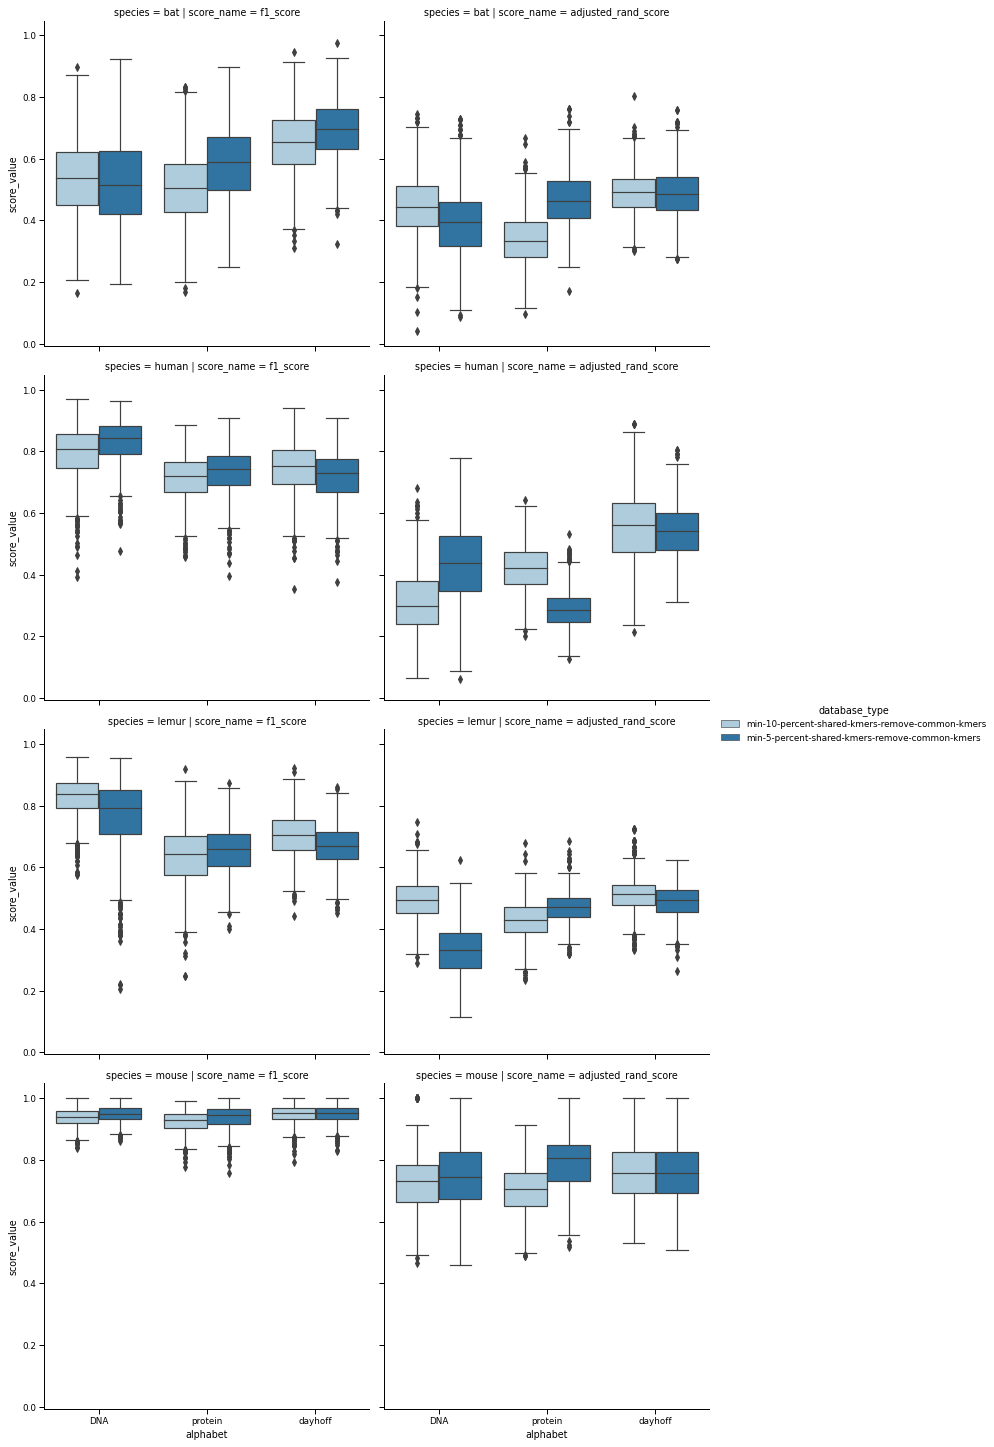

In [128]:
sns.catplot(
    
    data=human_broad_classification_metrics,
    x="alphabet",
    y="score_value",
    col="score_name",
    hue='database_type',
    row="species",
    kind='box',
    palette='Paired',
#     hue_order=species_order,
        order=alphabet_order
)

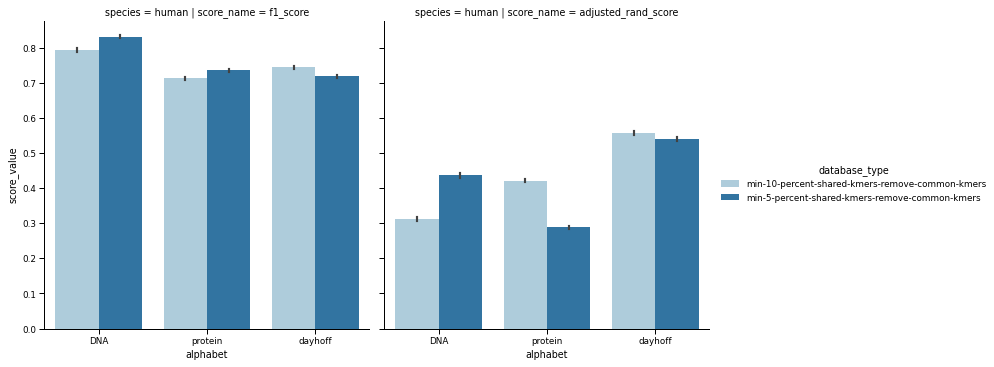

In [129]:
sns.catplot(
    
    data=human_broad_classification_metrics.query('species == "human"'),
    x="alphabet",
    y="score_value",
    col="score_name",
    hue='database_type',
    row="species",
    palette="Paired",
    kind='bar',
#     hue_order=species_order,
        order=alphabet_order
)

In [130]:
human_broad_classification_metrics.query(
    'alphabet == "dayhoff" and species == "human"'
).groupby(["alphabet", "score_name", "database_type", "species"]).score_value.mean()

alphabet  score_name           database_type                                    species
dayhoff   adjusted_rand_score  min-10-percent-shared-kmers-remove-common-kmers  human      0.557402
                               min-5-percent-shared-kmers-remove-common-kmers   human      0.539972
          f1_score             min-10-percent-shared-kmers-remove-common-kmers  human      0.744081
                               min-5-percent-shared-kmers-remove-common-kmers   human      0.719058
Name: score_value, dtype: float64

In [131]:
broad_classification_metrics["alpha_ksize"] = broad_classification_metrics.apply(
    lambda x: "{alphabet}, k: {ksize}".format(**x), axis=1
)

## Compute Confusion matrices

In [132]:
databases_to_choose

('min-10-percent-shared-kmers-remove-common-kmers',
 'min-5-percent-shared-kmers-remove-common-kmers')

In [133]:
"""
The F1 score can be interpreted as a weighted average of the precision and recall, 
where an F1 score reaches its best value at 1 and worst score at 0
"""

"""
By definition a confusion matrix is such that is equal to the number of 
observations known to be in group and predicted to be in group
"""

top_hit_confusion_dfs = {}

for keys, df in predicted_cells.query("database_type in @databases_to_choose").groupby(
    scoring_groupby
):

    ground_truth = df[ground_truth_celltype_col]
    predicted = df[predicted_celltype_col]
    weight = df["similarity"]
    labels = sorted(list(set(ground_truth) | set(predicted)))

    cm = confusion_matrix(
        ground_truth,
        predicted,
        #         labels=labels,
        #         sample_weight=weight
    )
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    cm_df.index.name = "ground_truth"
    cm_df.columns.name = "predicted"
    cm_df = cm_df.reindex(index=SHARED_CELLTYPES, columns=SHARED_CELLTYPES)
    #     cm_df = cm_df.loc[SHARED_CELLTYPES, SHARED_CELLTYPES]
    top_hit_confusion_dfs[keys] = cm_df

### @paper Separately plot confusion matrices to fine tune parameters

In [134]:
# broad_to_compartment = one2one.obs.set_index('broad_group')['compartment_group']
# broad_to_compartment = broad_to_compartment.loc[~broad_to_compartment.index.duplicated()]
# broad_to_compartment.head()

### Assign confusion matrix folder


In [135]:
broad_confusion_matrix_folder = os.path.join(
    figure_folder, "confusion_matrices", "broad_group"
)
! mkdir -p $broad_confusion_matrix_folder

In [136]:
figure_folder

'/home/olga/googledrive/ImmuneEvolution/figures/kmermaid_classification_metrics'

In [137]:
# broad_to_compartment = broad_to_compartment.sort_values()
# broad_to_compartment

In [138]:
sns.set_context('paper')

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

/home/olga/miniconda3/envs/immune-evolution/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


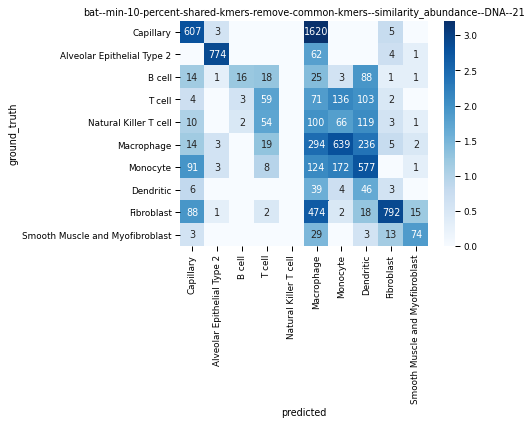

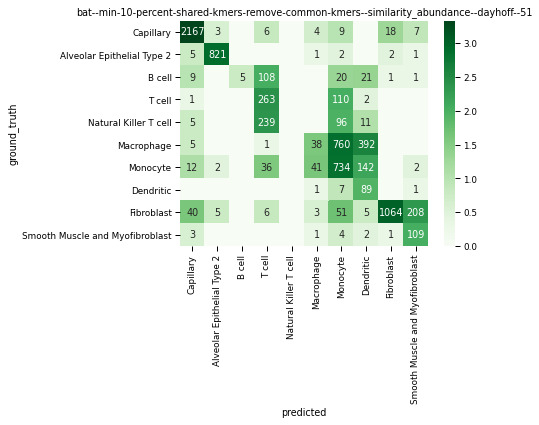

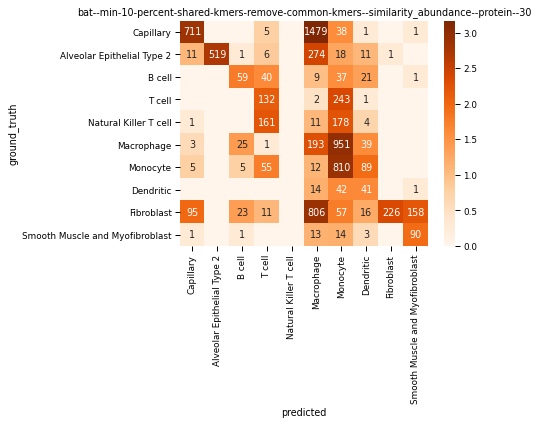

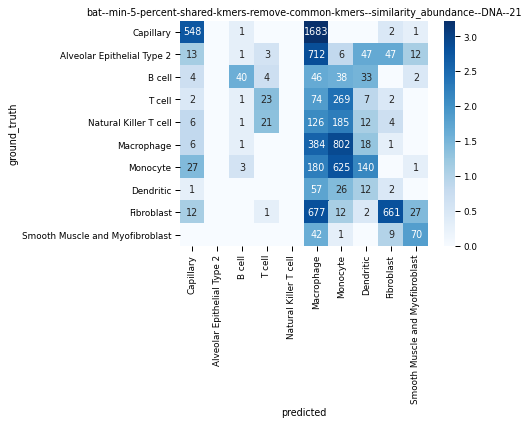

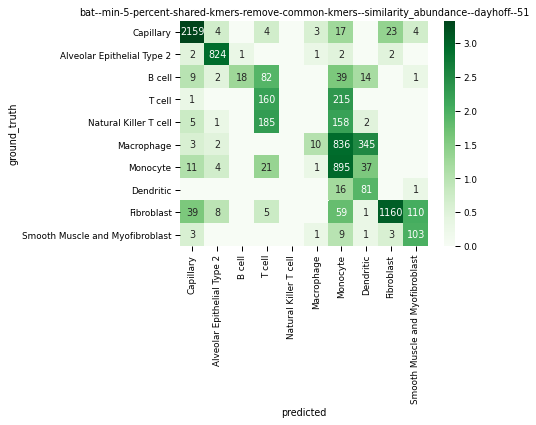

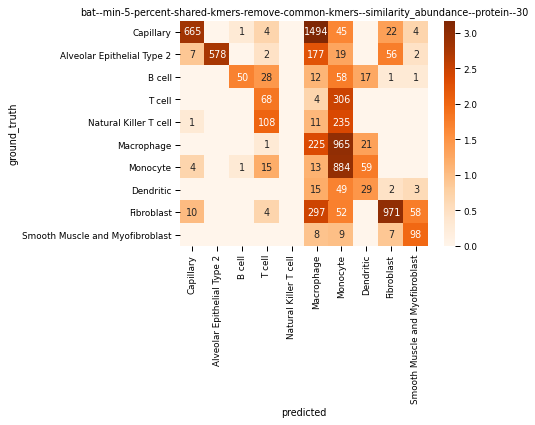

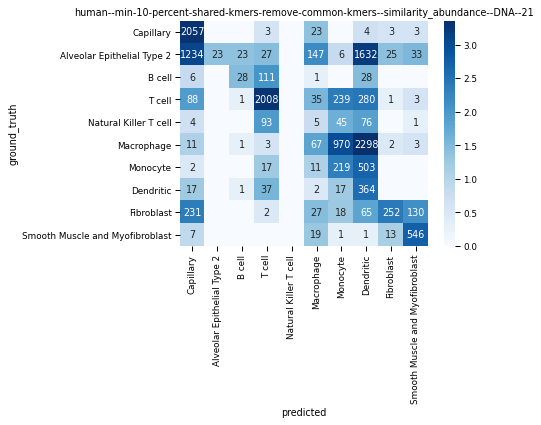

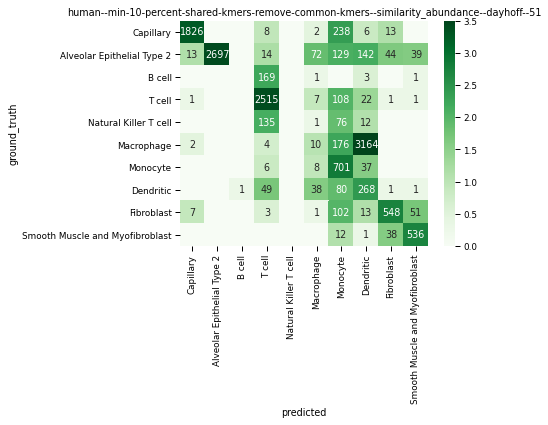

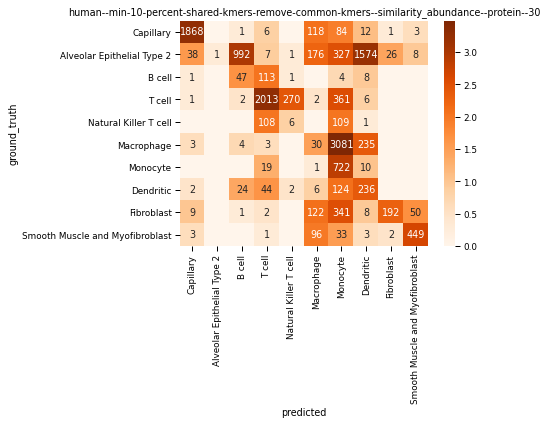

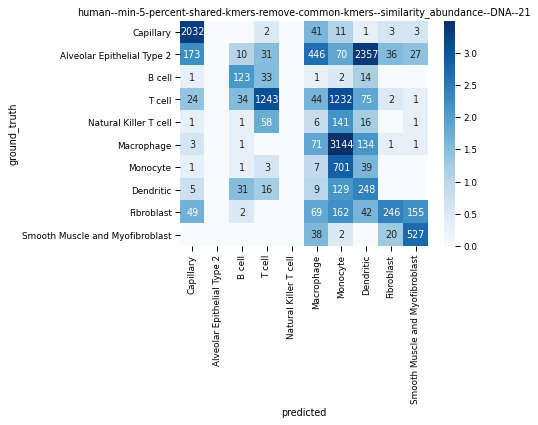

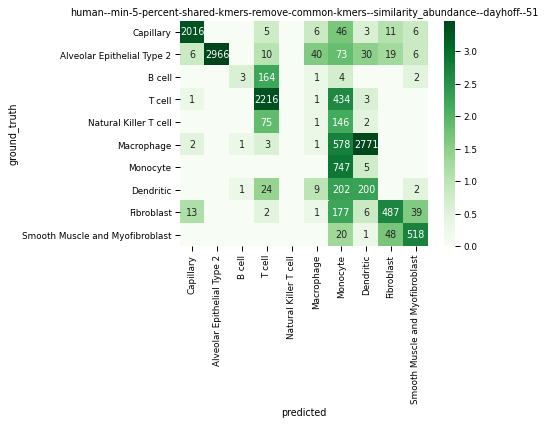

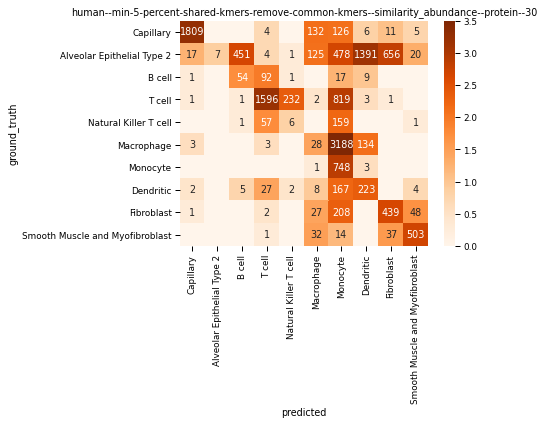

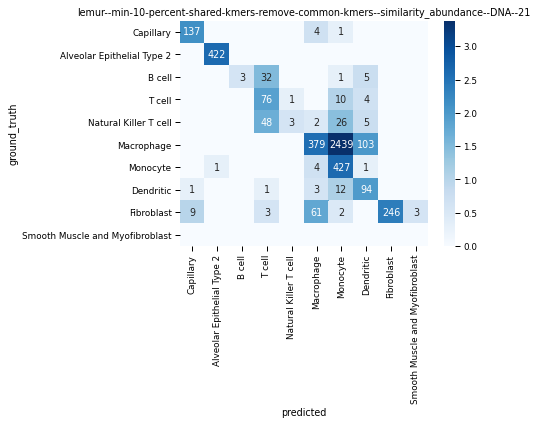

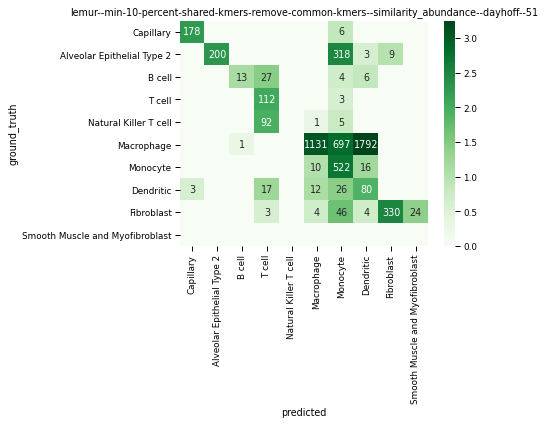

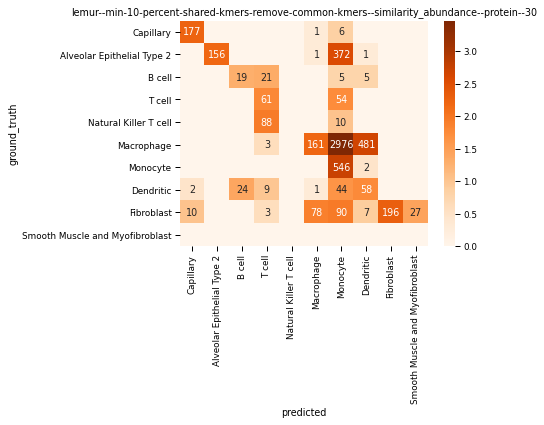

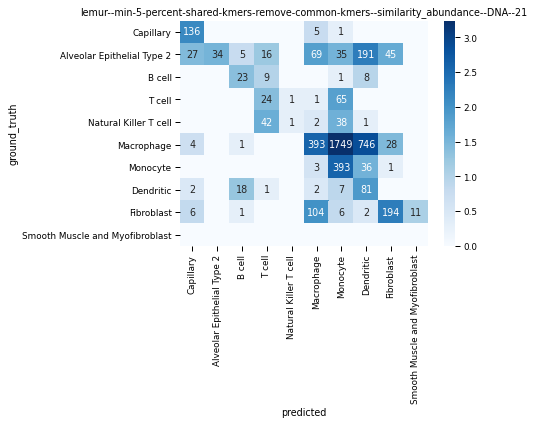

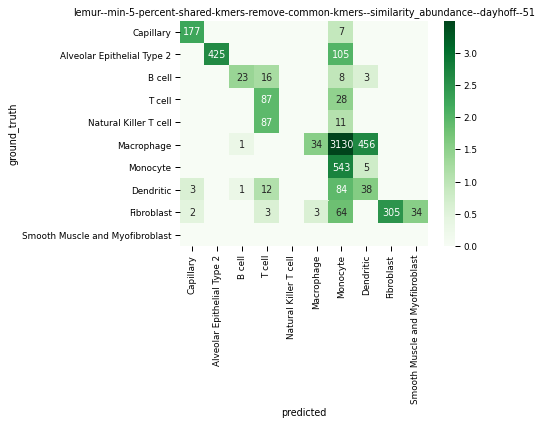

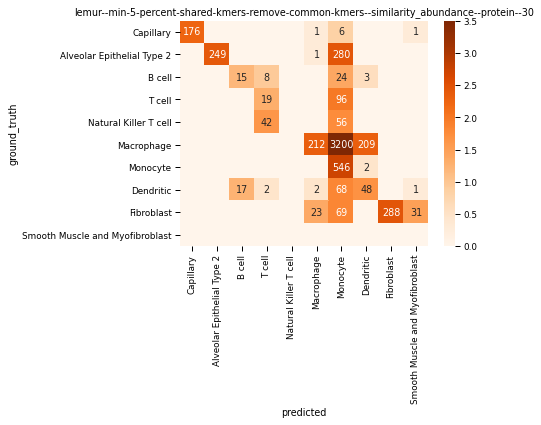

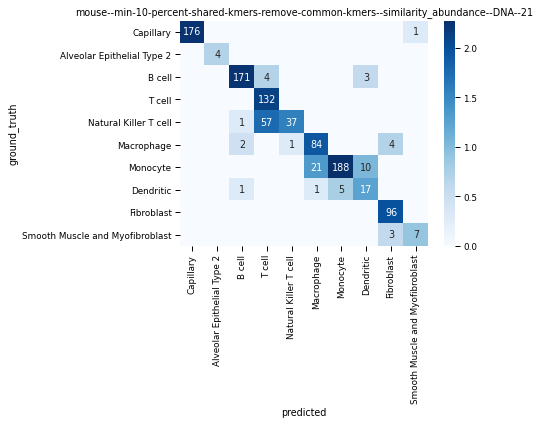

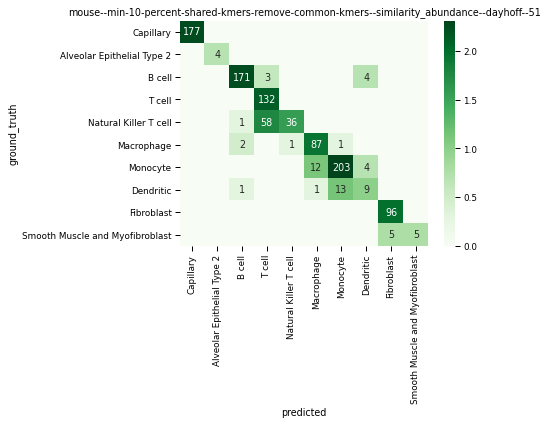

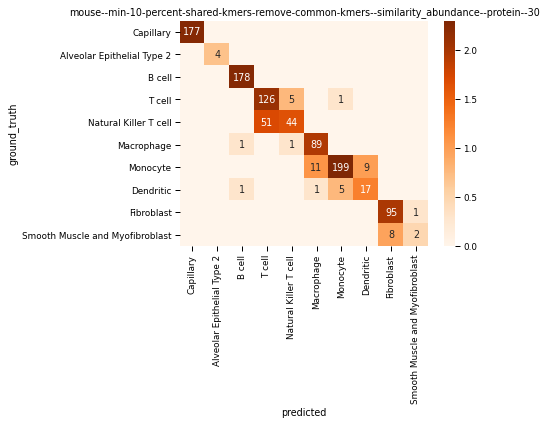

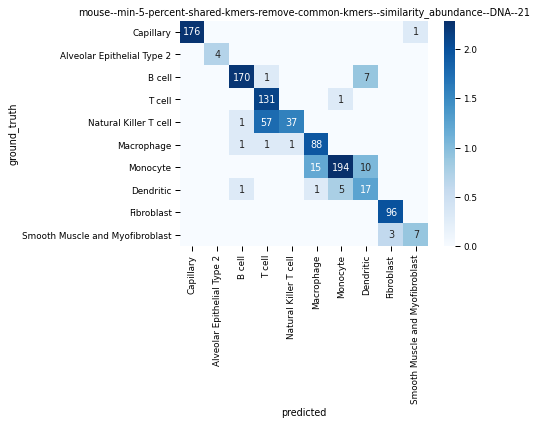

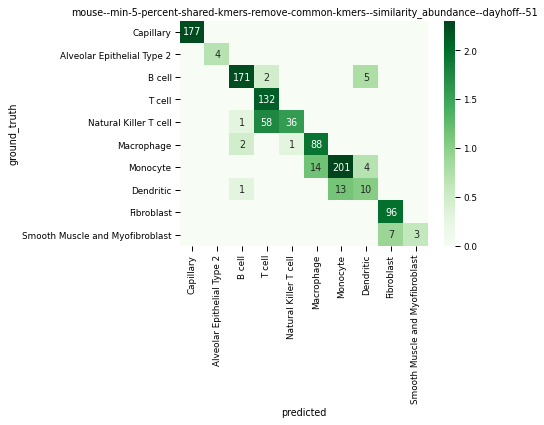

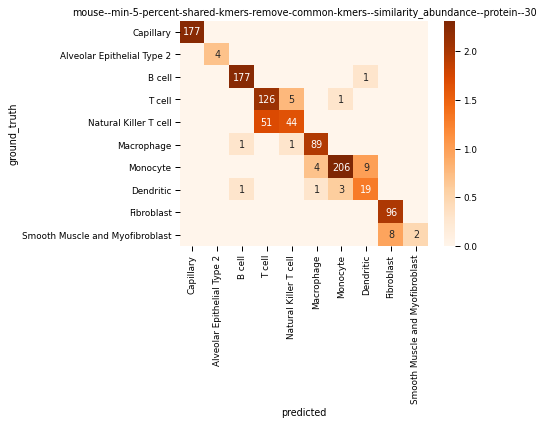

In [139]:
for keys, confusion_df in top_hit_confusion_dfs.items():
#     ksize, alphabet = keys
    fig, ax = plt.subplots(figsize=(7, 6))
    
    # Reorder by compartment
#     index = broad_to_compartment.index.intersection(confusion_df.index)
#     renamer = {broad: f'{broad} ({compartment[:3]})' for broad, compartment in broad_to_compartment[index].items()}
#     confusion_df = confusion_df.loc[index, index]
#     confusion_df = confusion_df.rename(columns=renamer, index=renamer)
    
    
    # Annotate only where nonzero
    annot = confusion_df[confusion_df > 0]
    # Replace all NAs (previously 0s) with an empty string
    annot = annot.applymap(lambda x: '' if pd.isnull(x) else str(int(x)))
#     annot = True
    
    cmap = get_cmap_color(keys)
    sns.heatmap(np.log10(confusion_df + 1), annot=annot, fmt='s', cmap=cmap)
    title = '--'.join(map(str, keys))
    ax.set(title=title)
#     ax.set(title=f"Alphabet: {alphabet}, k-mer size: {ksize}")
    pdf = os.path.join(broad_confusion_matrix_folder, f'{title}.pdf')
    fig.tight_layout()

    fig.savefig(pdf)
    
#     break

# Compartment

## Booststrap and compute score

In [140]:
broad_to_compartment.unique()

array(['endothelial', 'epithelial', 'lymphoid', 'myeloid', 'stromal'],
      dtype=object)

In [141]:
%%time

scoring_groupby = ['species', 'database_type', 'alphabet', 'ksize']
ground_truth_celltype_col = 'groundtruth_compartment'
predicted_celltype_col = 'predicted_compartment'


grouped = predicted_cells.groupby(scoring_groupby)

dfs = Parallel(n_jobs=96)(
    delayed(classification_metrics.subsample_and_score)(
        df,
        scoring_groupby=scoring_groupby,
        keys=keys,
        predicted_celltype_col=predicted_celltype_col,
        ground_truth_celltype_col=ground_truth_celltype_col,
        labels=broad_to_compartment.unique(),
    )
    for keys, df in tqdm(grouped, total=len(grouped))
)
compartment_metrics = pd.concat(
    dfs, ignore_index=True
)
describe(compartment_metrics)

100%|██████████| 68/68 [00:00<00:00, 193.23it/s]


(136000, 7)
--- First 5 entries ---


,species,database_type,alphabet,ksize,score_value,score_name,iteration
0,bat,min-10-percent-shared-kmers,DNA,21,0.582338,f1_score,0
1,bat,min-10-percent-shared-kmers,DNA,21,0.317829,adjusted_rand_score,0
2,bat,min-10-percent-shared-kmers,DNA,21,0.478242,f1_score,1
3,bat,min-10-percent-shared-kmers,DNA,21,0.188525,adjusted_rand_score,1
4,bat,min-10-percent-shared-kmers,DNA,21,0.566352,f1_score,2


CPU times: user 3.55 s, sys: 314 ms, total: 3.87 s
Wall time: 1min 19s


### Plot compartment metrics

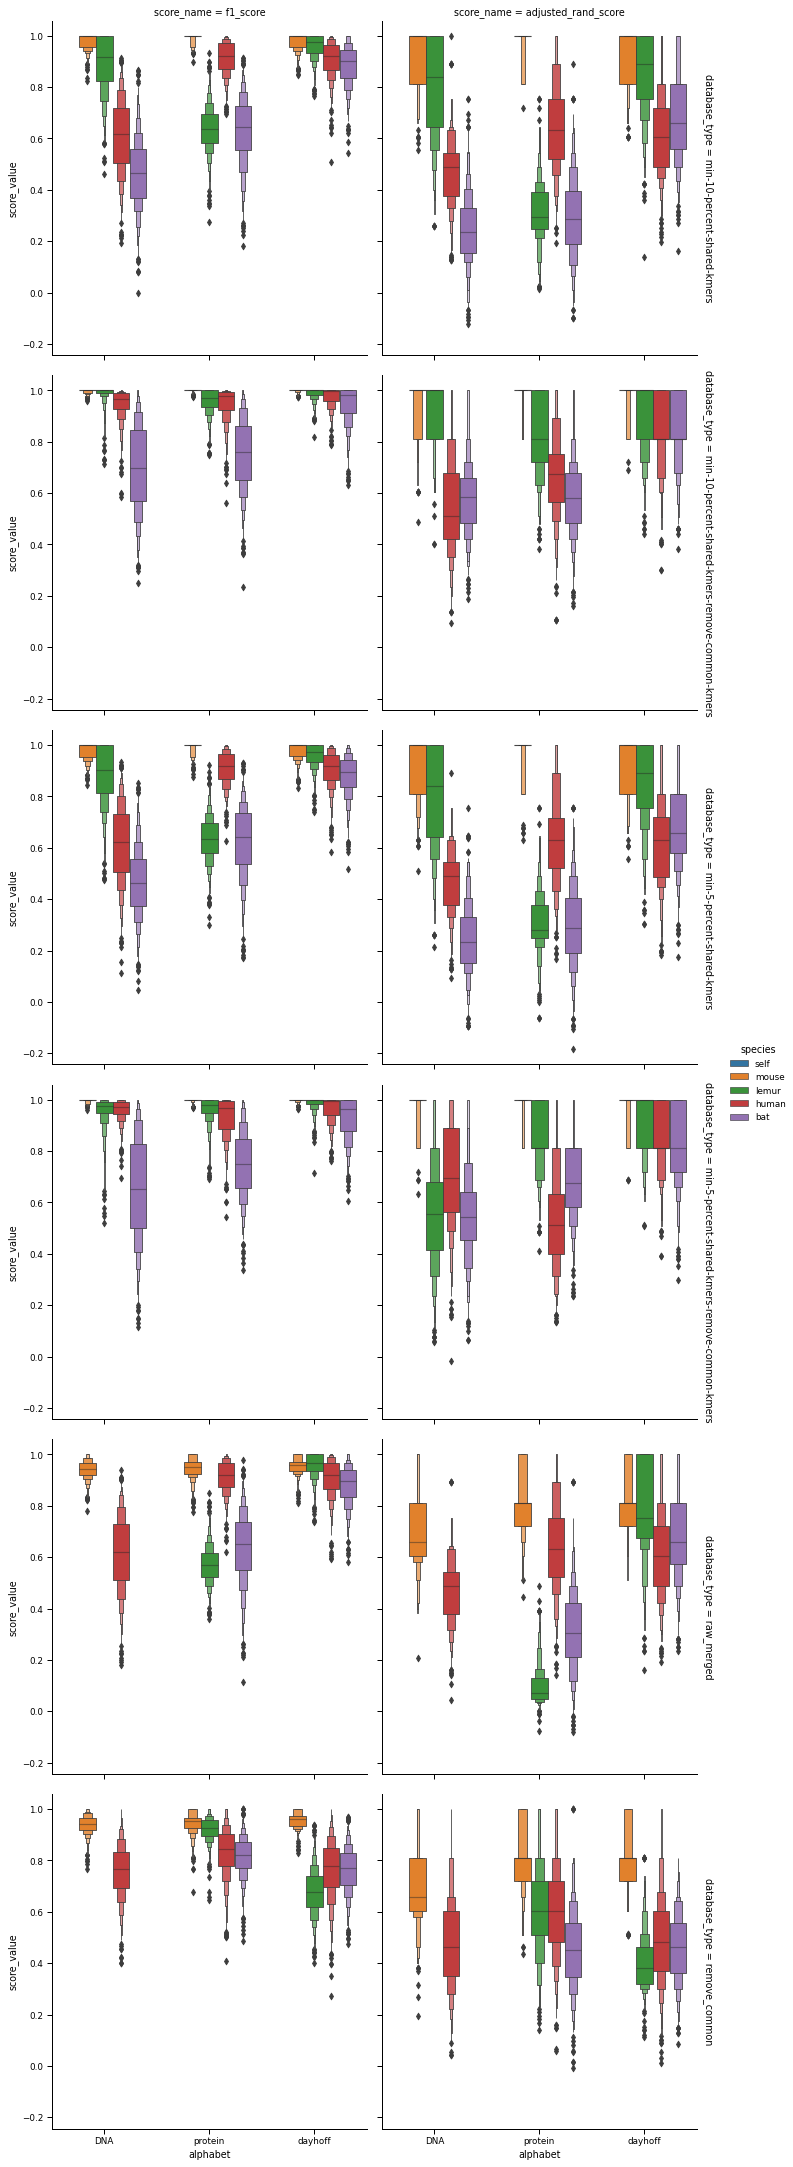

In [142]:
sns.catplot(
    
    data=compartment_metrics,
    x="alphabet",
    y="score_value",
    col="score_name",
    row='database_type',
    hue="species",
    kind='boxen',
    hue_order=species_order,
    order=alphabet_order,
    margin_titles=True
)

In [143]:
compartment_metrics.query(
    'alphabet == "dayhoff" and species == "human"'
).groupby(["alphabet", "score_name", "database_type", "species"]).score_value.mean()

alphabet  score_name           database_type                                    species
dayhoff   adjusted_rand_score  min-10-percent-shared-kmers                      human      0.607611
                               min-10-percent-shared-kmers-remove-common-kmers  human      0.850658
                               min-5-percent-shared-kmers                       human      0.612666
                               min-5-percent-shared-kmers-remove-common-kmers   human      0.871034
                               raw_merged                                       human      0.609981
                               remove_common                                    human      0.488434
          f1_score             min-10-percent-shared-kmers                      human      0.909501
                               min-10-percent-shared-kmers-remove-common-kmers  human      0.975862
                               min-5-percent-shared-kmers                       human      0.908879
            

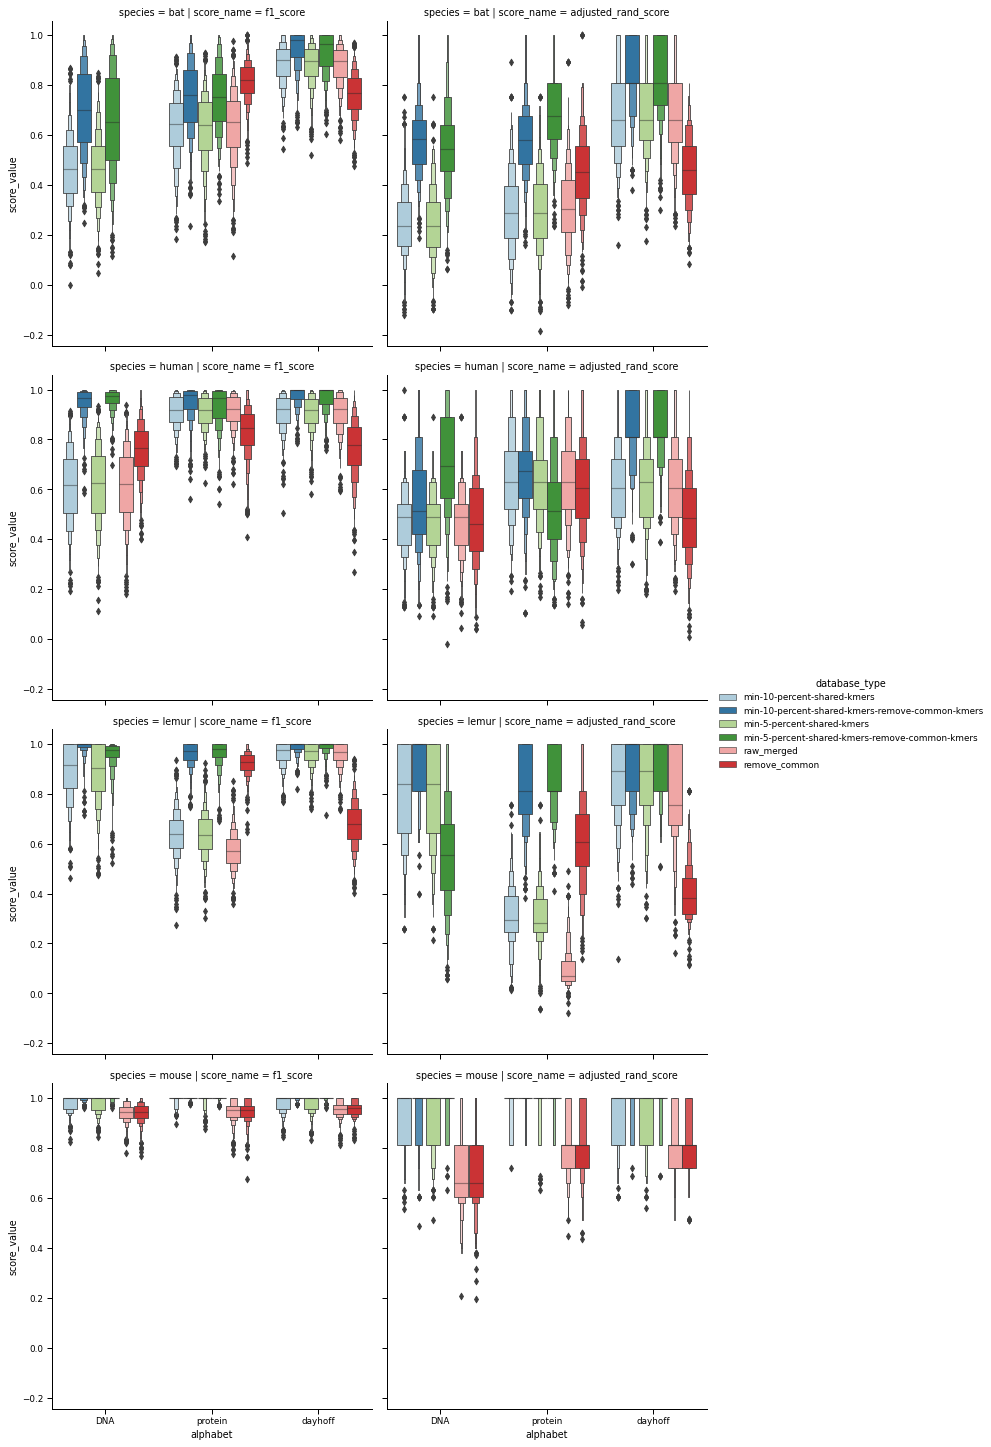

In [144]:
sns.catplot(
    
    data=compartment_metrics,
    x="alphabet",
    y="score_value",
    col="score_name",
    hue='database_type',
    row="species",
    kind='boxen',
#     hue_order=hue_order,
    order=alphabet_order,
    palette='Paired'
)

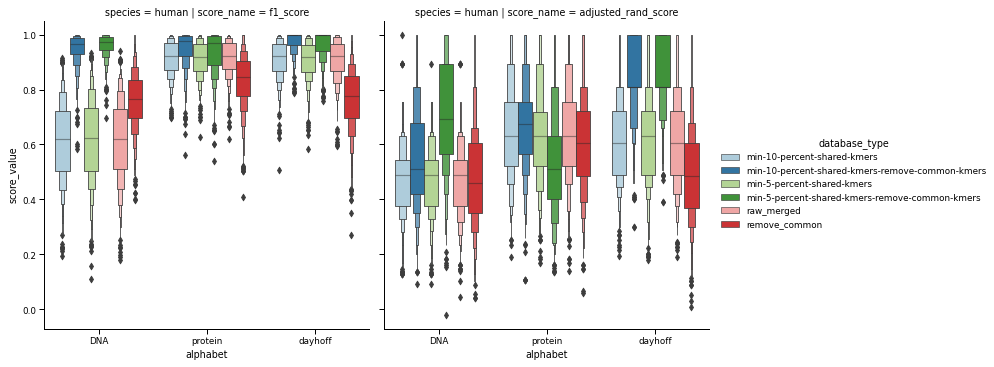

In [145]:
sns.catplot(
    
    data=compartment_metrics.query('species == "human"'),
    x="alphabet",
    y="score_value",
    col="score_name",
    hue='database_type',
    row="species",
    kind='boxen',
#     hue_order=hue_order,
    order=alphabet_order,
    palette='Paired'
)

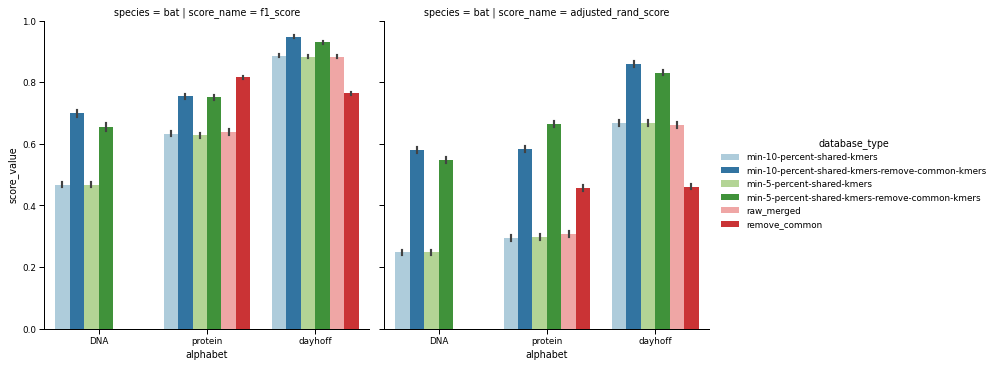

In [146]:
sns.catplot(
    
    data=compartment_metrics.query('species == "bat"'),
    x="alphabet",
    y="score_value",
    col="score_name",
    hue='database_type',
    row="species",
    kind='bar',
#     hue_order=hue_order,
    order=alphabet_order,
    palette='Paired'
)

### @paper resized, small barplot of F1 and Adjusted Rand scores

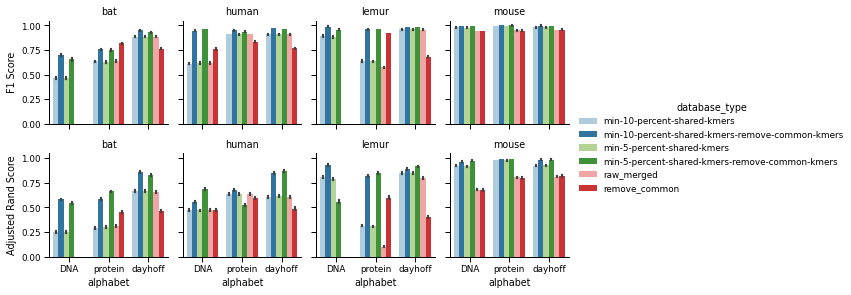

In [147]:
g = sns.catplot(
    
    data=compartment_metrics,
    x="alphabet",
    y="score_value",
    row="score_name",
    hue='database_type',
    col="species",
    kind='bar',
#     hue_order=hue_order,
    order=alphabet_order,
    palette='Paired',
    height=2,
#     margin_titles=True
)
g.set_titles('{col_name}')
for ax in g.axes.flat:
    if ax.is_first_col():
        if ax.is_first_row():
            ax.set_ylabel('F1 Score')
        elif ax.is_last_row():
            ax.set_ylabel("Adjusted Rand Score")
        

## Compute Confusion matrices

In [148]:
"""
The F1 score can be interpreted as a weighted average of the precision and recall, 
where an F1 score reaches its best value at 1 and worst score at 0
"""

"""
By definition a confusion matrix is such that is equal to the number of 
observations known to be in group and predicted to be in group
"""

compartment_confusion_dfs = {}

for keys, df in predicted_cells.groupby(scoring_groupby):

    ground_truth = df[ground_truth_celltype_col]
    predicted = df[predicted_celltype_col]
    weight = df["similarity"]
    labels = sorted(list(set(ground_truth) | set(predicted)))

    cm = confusion_matrix(
        ground_truth,
        predicted,
        #         labels=labels,
        #         sample_weight=weight
    )
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    cm_df.index.name = "ground_truth"
    cm_df.columns.name = "predicted"
#     cm_df = cm_df.reindex(index=SHARED_CELLTYPES, columns=SHARED_CELLTYPES)
#     cm_df = cm_df.loc[SHARED_CELLTYPES, SHARED_CELLTYPES]
    compartment_confusion_dfs[keys] = cm_df

### @paper Separately plot confusion matrices to fine tune parameters

In [149]:
# broad_to_compartment = one2one.obs.set_index('broad_group')['compartment_group']
# broad_to_compartment = broad_to_compartment.loc[~broad_to_compartment.index.duplicated()]
# broad_to_compartment.head()

In [150]:
# broad_to_compartment = broad_to_compartment.sort_values()
# broad_to_compartment

In [151]:
compartment_confusion_matrix_folder = os.path.join(
    figure_folder, "confusion_matrices", "compartment_group"
)
! mkdir -p $compartment_confusion_matrix_folder

In [152]:
1+1

2

/home/olga/miniconda3/envs/immune-evolution/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


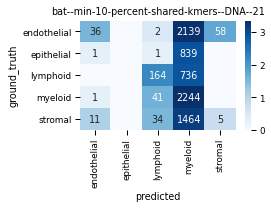

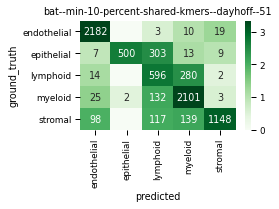

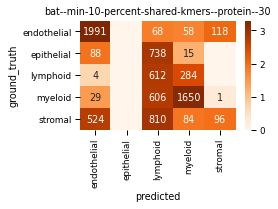

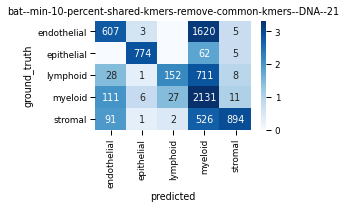

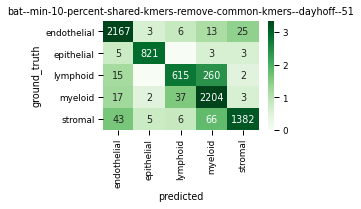

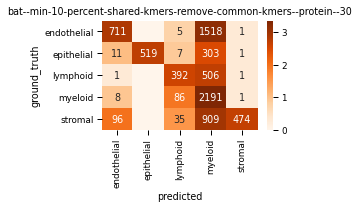

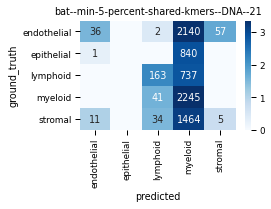

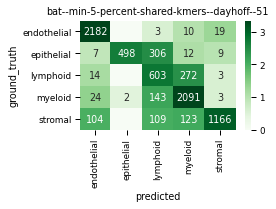

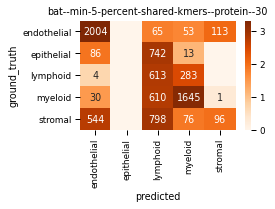

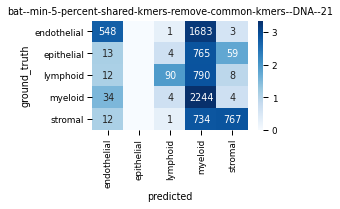

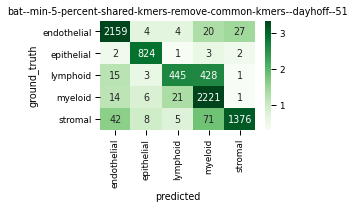

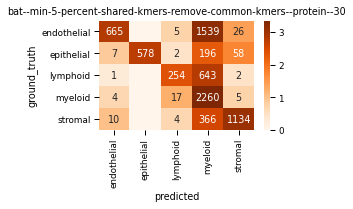

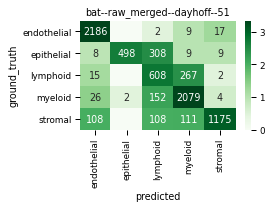

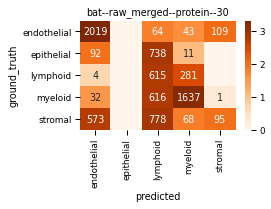

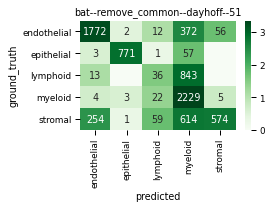

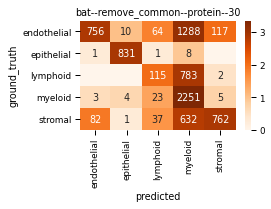

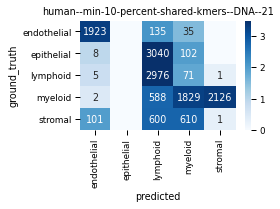

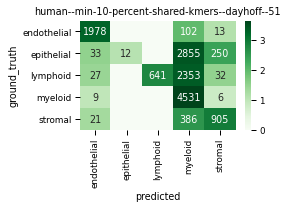

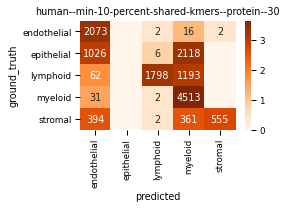

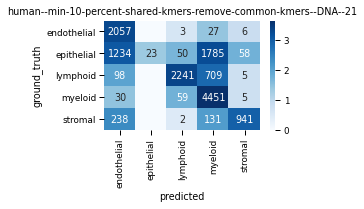

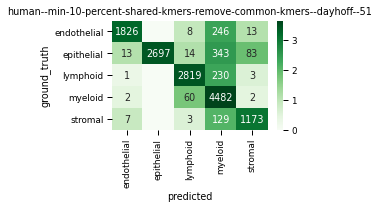

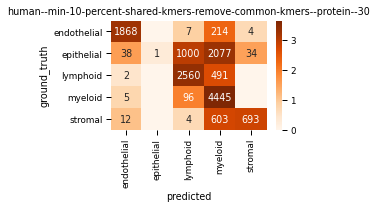

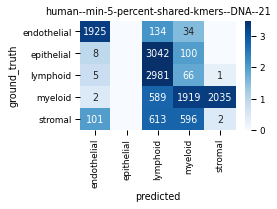

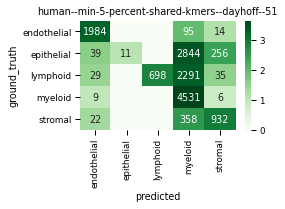

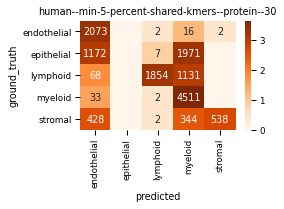

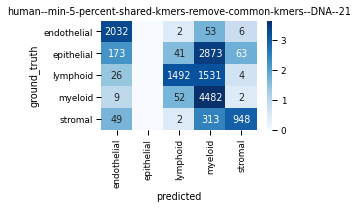

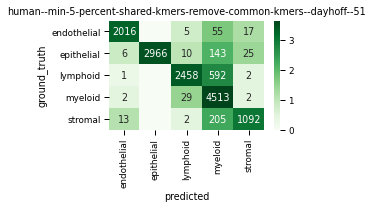

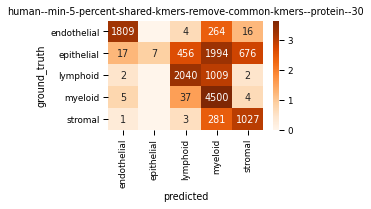

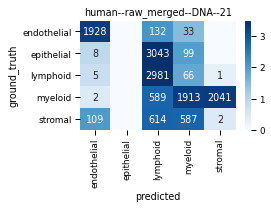

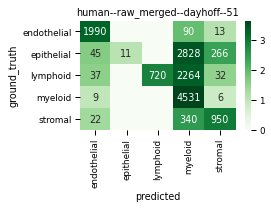

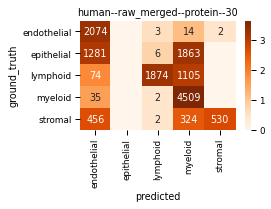

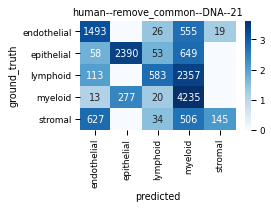

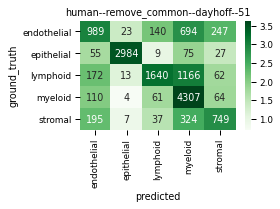

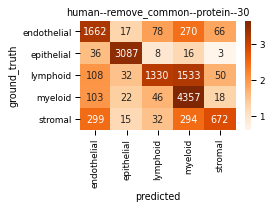

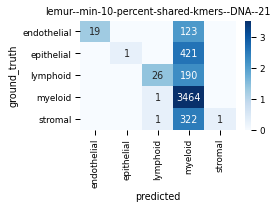

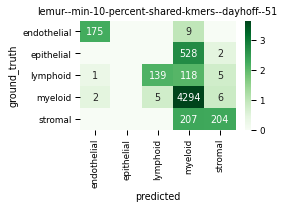

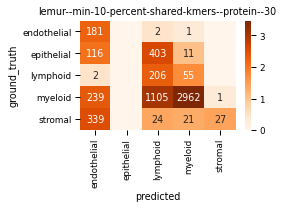

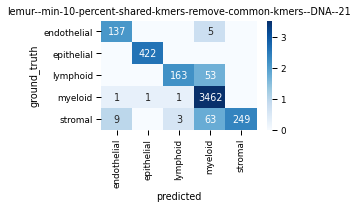

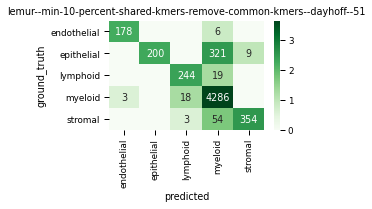

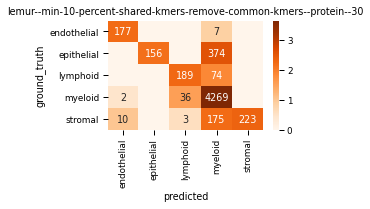

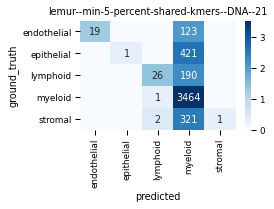

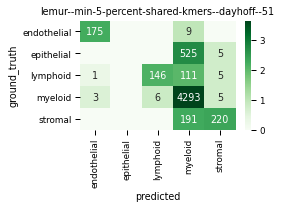

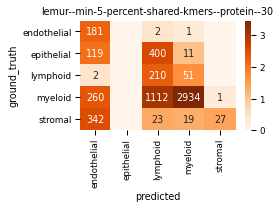

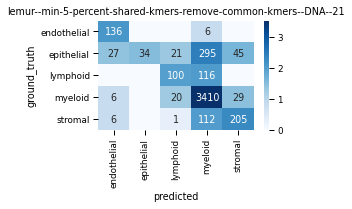

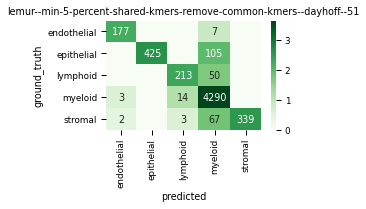

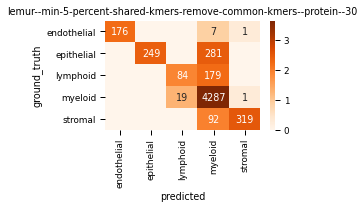

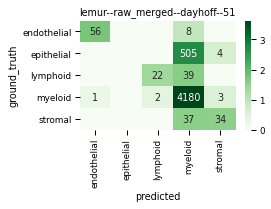

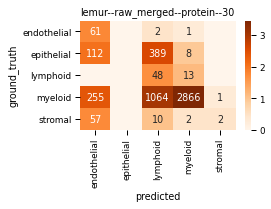

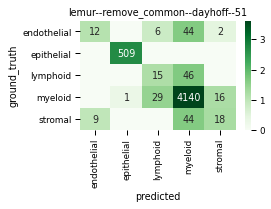

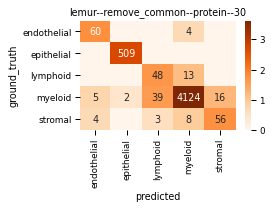

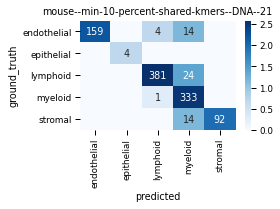

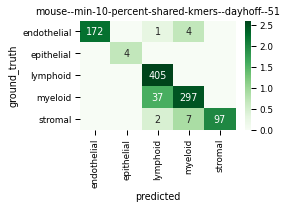

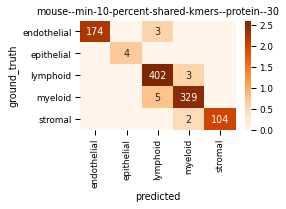

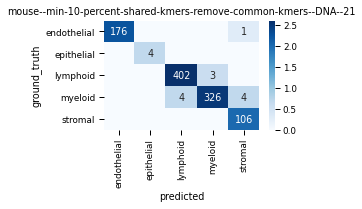

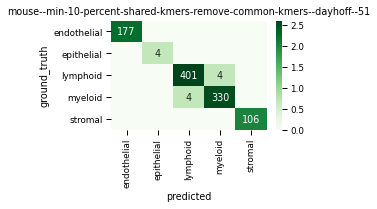

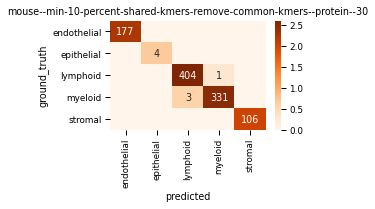

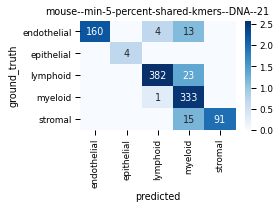

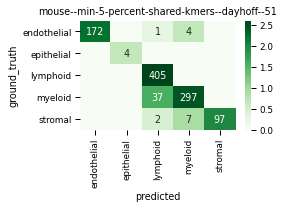

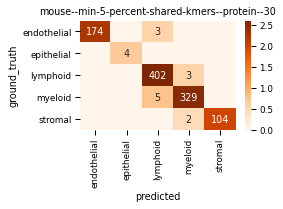

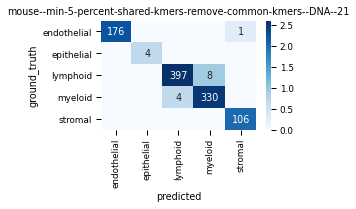

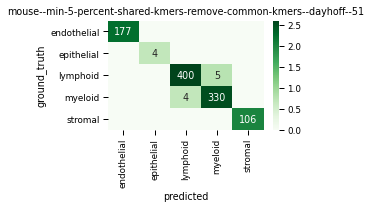

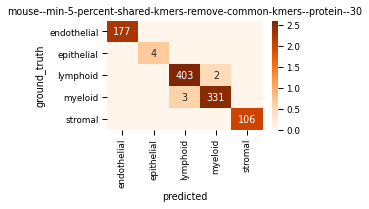

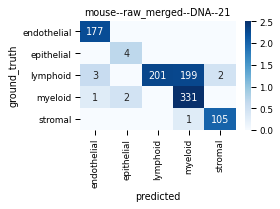

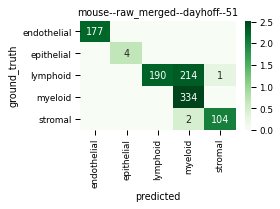

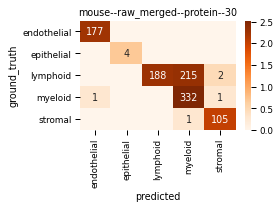

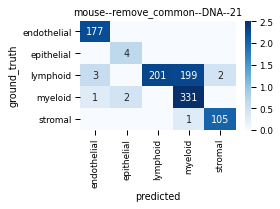

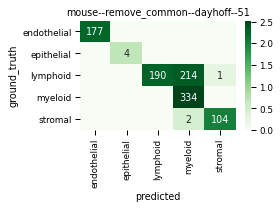

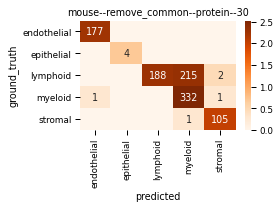

In [153]:

for keys, confusion_df in compartment_confusion_dfs.items():
#     ksize, alphabet = keys
    fig, ax = plt.subplots(figsize=(4, 3))
    
    # Reorder by compartment
#     index = broad_to_compartment.index.intersection(confusion_df.index)
#     renamer = {broad: f'{broad} ({compartment[:3]})' for broad, compartment in broad_to_compartment[index].items()}
#     confusion_df = confusion_df.loc[index, index]
#     confusion_df = confusion_df.rename(columns=renamer, index=renamer)
    
    
    # Annotate only where nonzero
    annot = confusion_df[confusion_df > 0]
    # Replace all NAs (previously 0s) with an empty string
    annot = annot.applymap(lambda x: '' if pd.isnull(x) else str(int(x)))
#     annot = True
    
    cmap = get_cmap_color(keys)
    sns.heatmap(np.log10(confusion_df + 1), annot=annot, fmt='s', cmap=cmap)
    title = '--'.join(map(str, keys))
    ax.set(title=title)
#     ax.set(title=f"Alphabet: {alphabet}, k-mer size: {ksize}")
    pdf = os.path.join(compartment_confusion_matrix_folder, f'{title}.pdf')
    fig.tight_layout()
    fig.savefig(pdf)

# Concatenate classification metrics

In [154]:
compartment_metrics.groupby(['species', 'database_type']).size()

species  database_type                                  
bat      min-10-percent-shared-kmers                        6000
         min-10-percent-shared-kmers-remove-common-kmers    6000
         min-5-percent-shared-kmers                         6000
         min-5-percent-shared-kmers-remove-common-kmers     6000
         raw_merged                                         4000
         remove_common                                      4000
human    min-10-percent-shared-kmers                        6000
         min-10-percent-shared-kmers-remove-common-kmers    6000
         min-5-percent-shared-kmers                         6000
         min-5-percent-shared-kmers-remove-common-kmers     6000
         raw_merged                                         6000
         remove_common                                      6000
lemur    min-10-percent-shared-kmers                        6000
         min-10-percent-shared-kmers-remove-common-kmers    6000
         min-5-percent-shared-kme

In [155]:
broad_classification_metrics['grouping'] = 'celltype'
compartment_metrics['grouping'] = 'compartment'

In [156]:
broad_classification_metrics.database_type.unique()

array(['min-10-percent-shared-kmers',
       'min-10-percent-shared-kmers-remove-common-kmers',
       'min-5-percent-shared-kmers',
       'min-5-percent-shared-kmers-remove-common-kmers', 'raw_merged',
       'remove_common'], dtype=object)

In [157]:
concatenated_metrics = pd.concat([broad_classification_metrics, compartment_metrics])
# concatenated_metrics = concatenated_metrics.query('database_type == "min-10-percent-shared-kmers-remove-common-kmers"')

# concatenated_metrics = concatenated_metrics.query('database_type == "remove_common"')
describe(concatenated_metrics)

(272000, 11)
--- First 5 entries ---


,species,database_type,search_method,alphabet,ksize,score_value,score_name,iteration,database_method,alpha_ksize,grouping
0,bat,min-10-percent-shared-kmers,similarity_abundance,DNA,21,0.313736,f1_score,0,min-10-percent-shared-kmers: similarity_abundance,"DNA, k: 21",celltype
1,bat,min-10-percent-shared-kmers,similarity_abundance,DNA,21,0.291510,adjusted_rand_score,0,min-10-percent-shared-kmers: similarity_abundance,"DNA, k: 21",celltype
2,bat,min-10-percent-shared-kmers,similarity_abundance,DNA,21,0.314381,f1_score,1,min-10-percent-shared-kmers: similarity_abundance,"DNA, k: 21",celltype
3,bat,min-10-percent-shared-kmers,similarity_abundance,DNA,21,0.270688,adjusted_rand_score,1,min-10-percent-shared-kmers: similarity_abundance,"DNA, k: 21",celltype
4,bat,min-10-percent-shared-kmers,similarity_abundance,DNA,21,0.173666,f1_score,2,min-10-percent-shared-kmers: similarity_abundance,"DNA, k: 21",celltype


In [158]:
concatenated_metrics_folder = os.path.join(
    figure_folder, "concatenated_metrics"
)
! mkdir -p $concatenated_metrics_folder

## Human

In [159]:
concatenated_metrics_human = concatenated_metrics.query('species == "human"')
concatenated_metrics_human.head()

,species,database_type,search_method,alphabet,ksize,score_value,score_name,iteration,database_method,alpha_ksize,grouping
32000,human,min-10-percent-shared-kmers,similarity_abundance,DNA,21,0.401768,f1_score,0,min-10-percent-shared-kmers: similarity_abundance,"DNA, k: 21",celltype
32001,human,min-10-percent-shared-kmers,similarity_abundance,DNA,21,0.249619,adjusted_rand_score,0,min-10-percent-shared-kmers: similarity_abundance,"DNA, k: 21",celltype
32002,human,min-10-percent-shared-kmers,similarity_abundance,DNA,21,0.380963,f1_score,1,min-10-percent-shared-kmers: similarity_abundance,"DNA, k: 21",celltype
32003,human,min-10-percent-shared-kmers,similarity_abundance,DNA,21,0.427526,adjusted_rand_score,1,min-10-percent-shared-kmers: similarity_abundance,"DNA, k: 21",celltype
32004,human,min-10-percent-shared-kmers,similarity_abundance,DNA,21,0.487887,f1_score,2,min-10-percent-shared-kmers: similarity_abundance,"DNA, k: 21",celltype


In [160]:
database_order

['raw_merged',
 'remove_common',
 'min-5-percent-shared-kmers-remove-common-kmers',
 'min-10-percent-shared-kmers-remove-common-kmers']

In [161]:
concatenated_metrics_folder

'/home/olga/googledrive/ImmuneEvolution/figures/kmermaid_classification_metrics/concatenated_metrics'

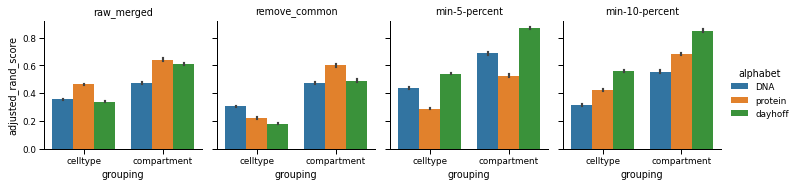

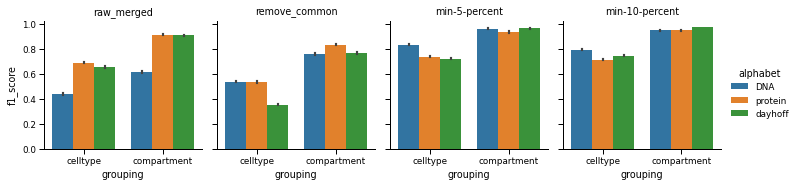

In [162]:
for score_name, df in concatenated_metrics_human.groupby("score_name"):
    g = sns.catplot(
        data=df,
        hue="alphabet",
        col="database_type",
        col_order=database_order,
        x="grouping",
        y="score_value",
        #         row="score_name",
        hue_order=alphabet_order,
        kind="bar",
        height=2.5,
#         palette="Set2",
    )
    g.set_titles("{col_name}")
    g.set_ylabels(score_name)
    for ax in g.axes.flat:
        title = ax.get_title()
        new_title = title.split('-shared-kmers')[0]
        ax.set(title=new_title)
#     pdf = os.path.join(
#         concatenated_metrics_folder,
#         f"human__barplot_metrics_per_species__hue-database_type__col-alphabet__{score_name}.pdf",
#     )
#     g.savefig(pdf)

In [163]:
pdf

'/home/olga/googledrive/ImmuneEvolution/figures/kmermaid_classification_metrics/confusion_matrices/compartment_group/mouse--remove_common--protein--30.pdf'

## Barplots

In [164]:
species_order

['self', 'mouse', 'lemur', 'human', 'bat']

In [165]:
species_order = ['mouse', 'human', 'lemur', 'bat']

## @paper score values for reference

In [166]:
1+1

2

#### Make alphabet categorical

In [167]:
concatenated_metrics['alphabet'] = pd.Categorical(concatenated_metrics['alphabet'], categories=alphabet_order, ordered=True)

In [168]:
database_type = "min-5-percent-shared-kmers"
mean_scores_tidy = (
    concatenated_metrics.query("database_type == @database_type and species != 'lemur'")
    .groupby(["database_type", "score_name", "species", "grouping", "alphabet"])
    .score_value.mean()
)

mean_scores = mean_scores_tidy.unstack(level=1)

# Write to excel
xlsx = os.path.join(
    concatenated_metrics_folder, f"concatenated-metrics--mean-scores--{database_type}.xlsx"
)
mean_scores.to_excel(xlsx)
describe(mean_scores)

(18, 2)
--- First 5 entries ---


score_name                                               adjusted_rand_score  \
database_type              species grouping    alphabet                        
min-5-percent-shared-kmers bat     celltype    DNA                  0.242936   
                                               protein              0.236425   
                                               dayhoff              0.400261   
                                   compartment DNA                  0.247468   
                                               protein              0.298404   

score_name                                               f1_score  
database_type              species grouping    alphabet            
min-5-percent-shared-kmers bat     celltype    DNA       0.273840  
                                               protein   0.443645  
                                               dayhoff   0.544350  
                                   compartment DNA       0.466957  
                                               protein   0.628059

--- min-10-percent-shared-kmers ---
--- min-10-percent-shared-kmers-remove-common-kmers ---
--- min-5-percent-shared-kmers ---
--- min-5-percent-shared-kmers-remove-common-kmers ---
--- raw_merged ---
--- remove_common ---


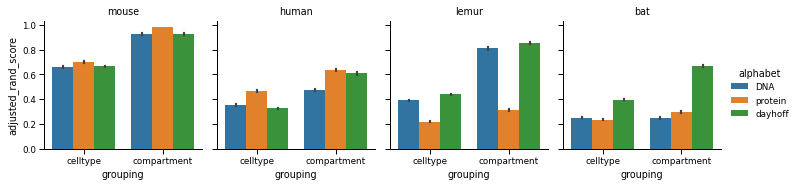

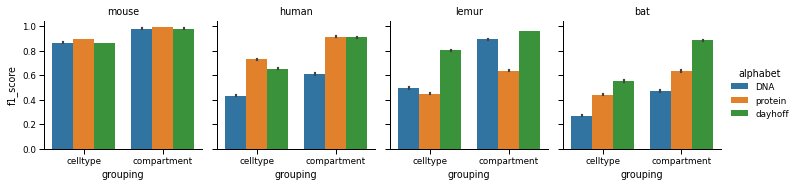

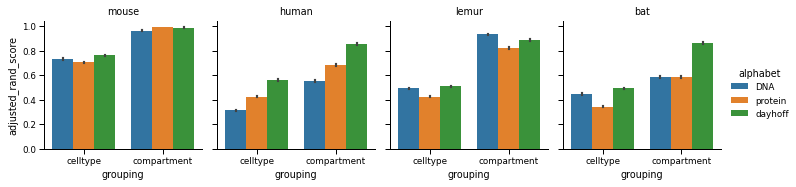

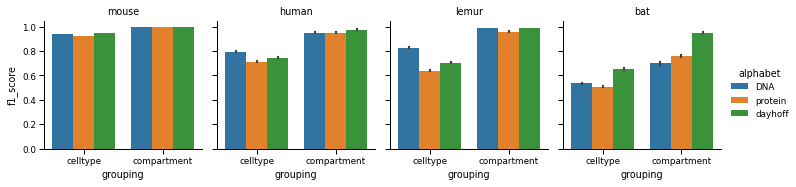

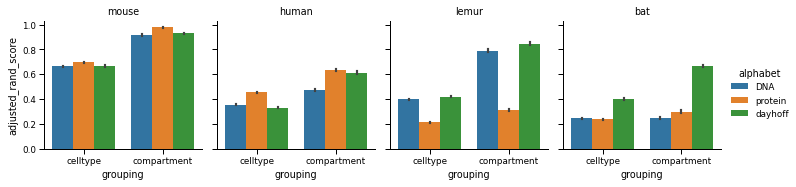

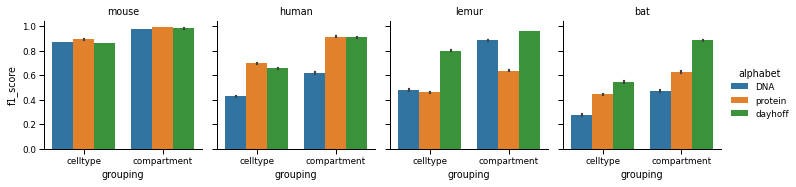

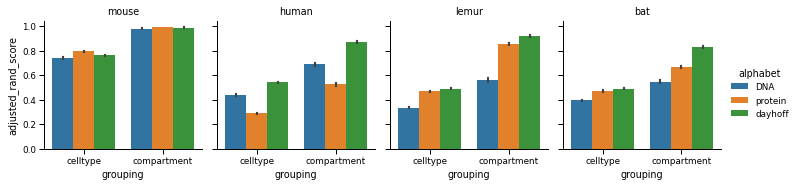

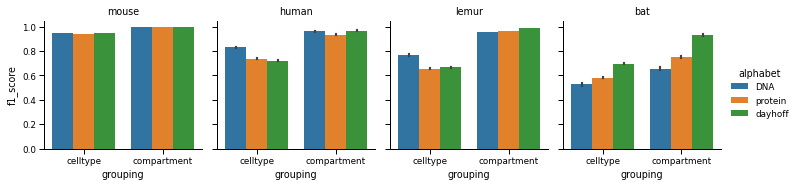

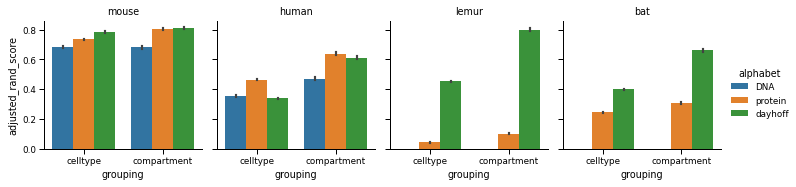

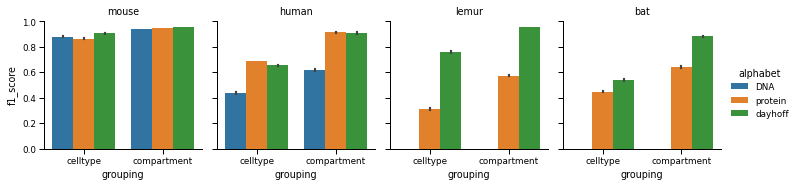

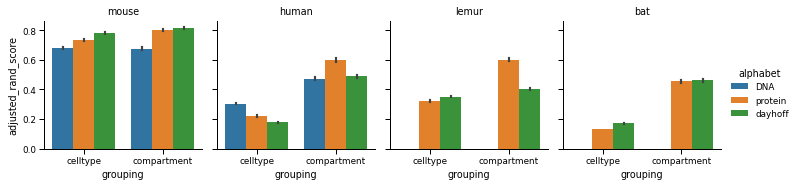

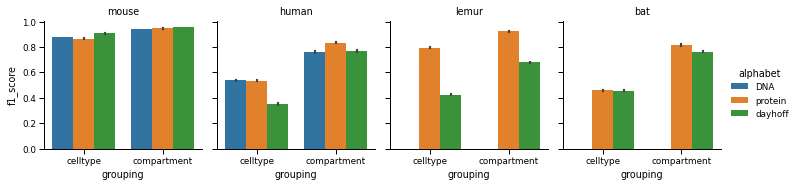

In [169]:
for database_type, database_df in concatenated_metrics.groupby('database_type'):
    print(f'--- {database_type} ---')

    for score_name, df in database_df.groupby('score_name'):
        g = sns.catplot(
            data=df,
            hue="alphabet",
            x="grouping",
            y="score_value",
            col="species",
            row="score_name",
            kind="bar",
            height=2.5,
            hue_order=alphabet_order,
            col_order=species_order,
            palette="tab10",
        )
        g.set_titles("{col_name}")
        g.set_ylabels(score_name)
        pdf = os.path.join(concatenated_metrics_folder, f"barplot_metrics_per_species__hue-alphabet__{database_type}__{score_name}.pdf")
        g.savefig(pdf)

--- min-10-percent-shared-kmers ---
--- min-10-percent-shared-kmers-remove-common-kmers ---
--- min-5-percent-shared-kmers ---
--- min-5-percent-shared-kmers-remove-common-kmers ---
--- raw_merged ---
--- remove_common ---


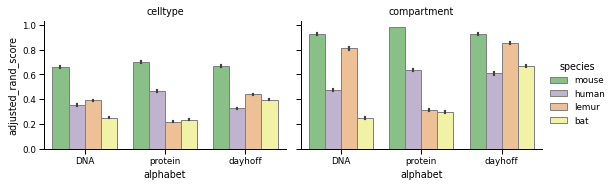

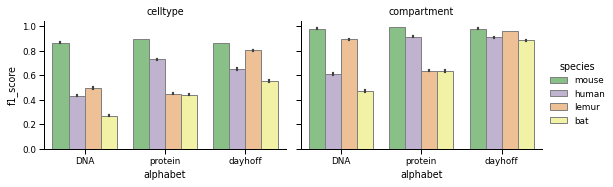

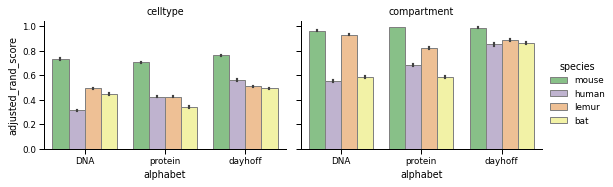

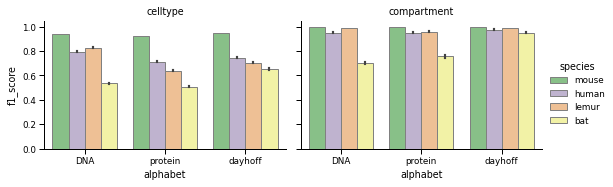

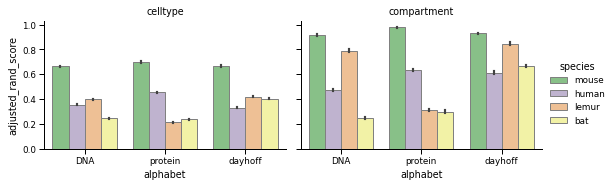

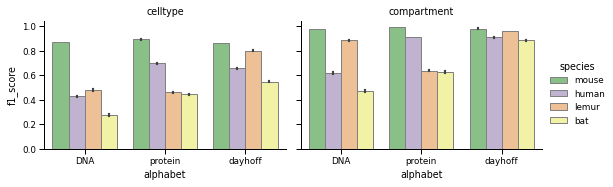

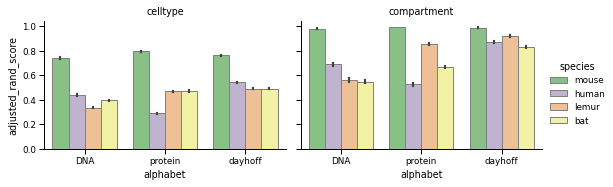

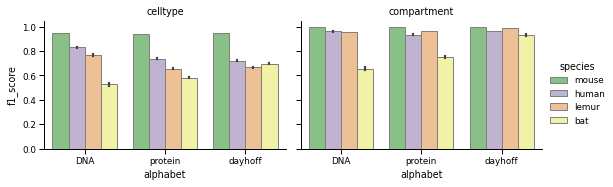

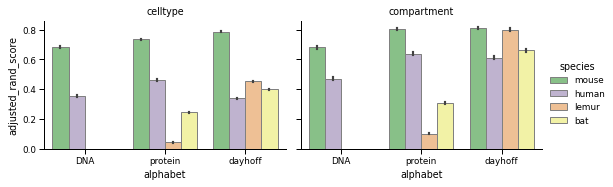

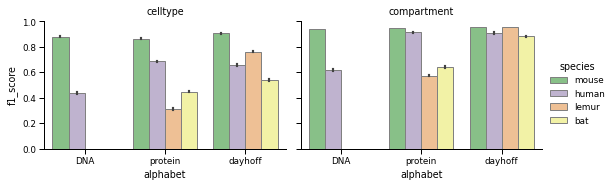

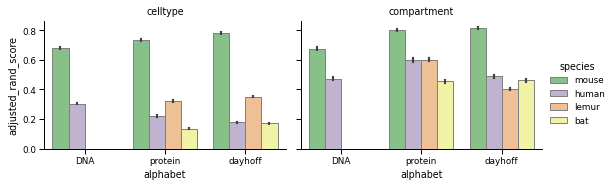

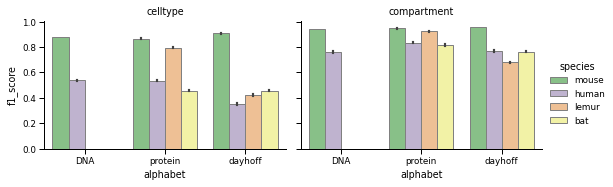

In [170]:
for database_type, database_df in concatenated_metrics.groupby('database_type'):
    print(f'--- {database_type} ---')

    for score_name, df in database_df.groupby('score_name'):
        g = sns.catplot(
            data=df,
            x="alphabet",
            col="grouping",
            y="score_value",
            hue="species",
            kind="bar",
            height=2.5,
            aspect=1.5,
            order=alphabet_order,
            hue_order=species_order,
            palette="Accent",
            linewidth=1,
            edgecolor='grey'
        )
        g.set_titles("{col_name}")
        g.set_ylabels(score_name)
        pdf = os.path.join(concatenated_metrics_folder, f"barplot_metrics_per_species__row-grouping__hue-species__{database_type}__{score_name}.pdf")
        g.savefig(pdf)

In [171]:
species_order

['mouse', 'human', 'lemur', 'bat']

In [172]:
species_order_no_lemur = ['mouse', 'human', 'bat']


--- min-10-percent-shared-kmers ---
--- min-10-percent-shared-kmers-remove-common-kmers ---
--- min-5-percent-shared-kmers ---
--- min-5-percent-shared-kmers-remove-common-kmers ---
--- raw_merged ---
--- remove_common ---


/home/olga/miniconda3/envs/immune-evolution/lib/python3.7/site-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


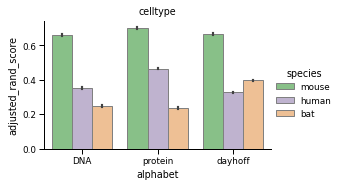

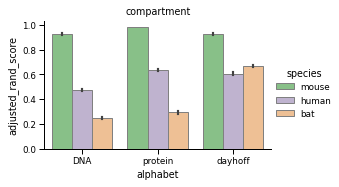

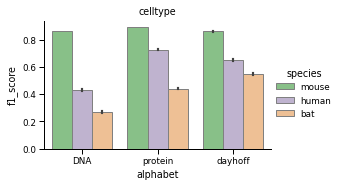

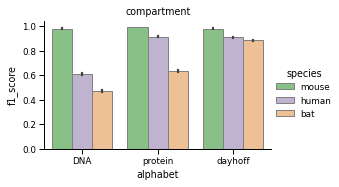

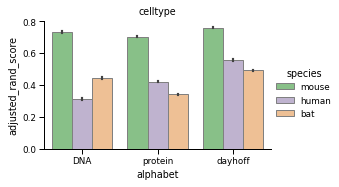

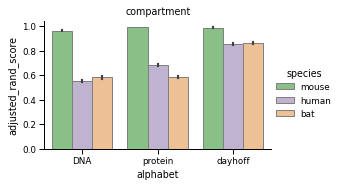

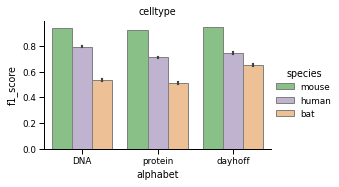

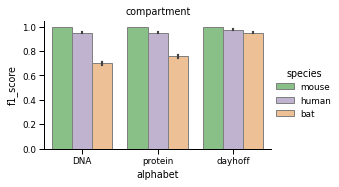

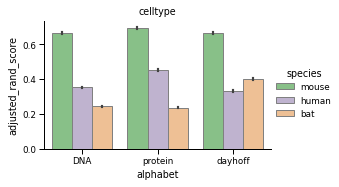

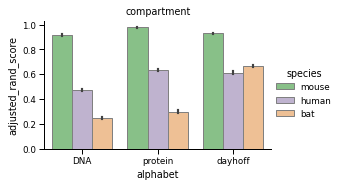

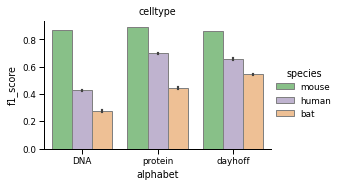

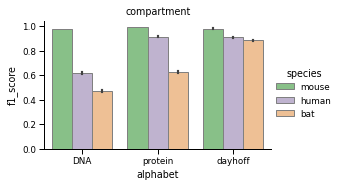

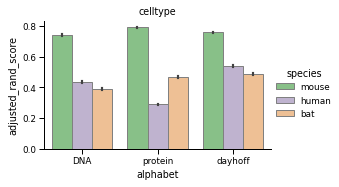

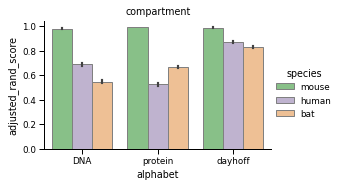

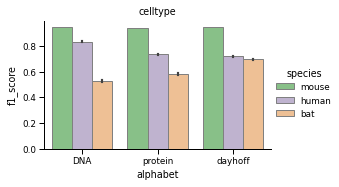

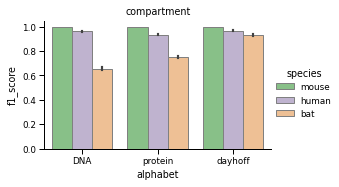

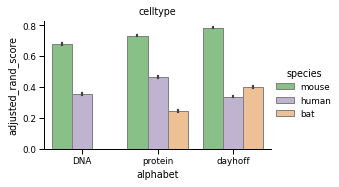

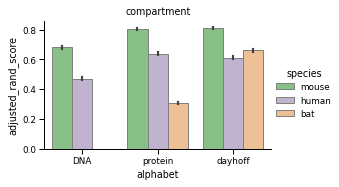

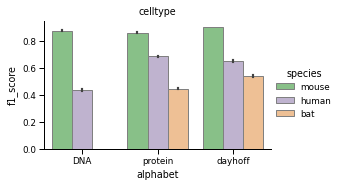

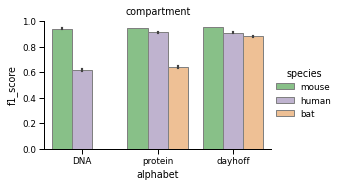

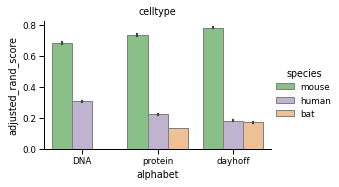

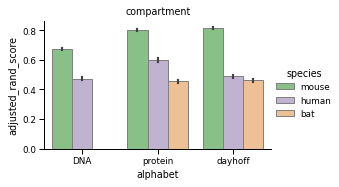

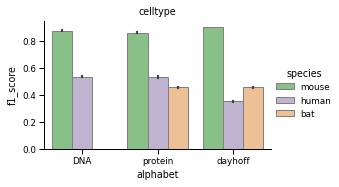

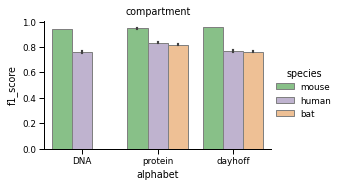

In [173]:
for database_type, database_df in concatenated_metrics.query('species != "lemur"').groupby('database_type'):
    print(f'--- {database_type} ---')

    for score_name, score_df in database_df.groupby('score_name'):
        for grouping, df in score_df.groupby('grouping'):
            g = sns.catplot(
                data=df,
                x="alphabet",
                col="grouping",
                y="score_value",
                hue="species",
                kind="bar",
                height=2.5,
                aspect=1.5,
                order=alphabet_order,
                hue_order=species_order_no_lemur,
                palette="Accent",
                linewidth=1,
                edgecolor='grey'
            )
            g.set_titles("{col_name}")
            g.set_ylabels(score_name)
            pdf = os.path.join(concatenated_metrics_folder, f"barplot_metrics_per_species__row-grouping__hue-species__{database_type}__{score_name}__{grouping}__no_lemur.pdf")
            g.savefig(pdf)

In [174]:
pdf

'/home/olga/googledrive/ImmuneEvolution/figures/kmermaid_classification_metrics/concatenated_metrics/barplot_metrics_per_species__row-grouping__hue-species__remove_common__f1_score__compartment__no_lemur.pdf'

--- min-10-percent-shared-kmers ---
--- min-10-percent-shared-kmers-remove-common-kmers ---
--- min-5-percent-shared-kmers ---
--- min-5-percent-shared-kmers-remove-common-kmers ---
--- raw_merged ---
--- remove_common ---


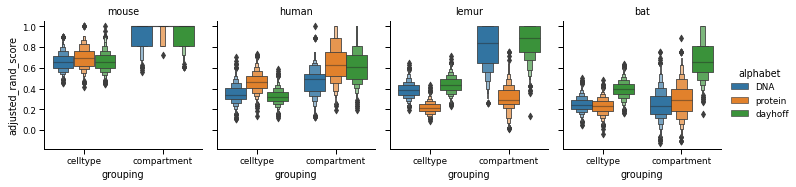

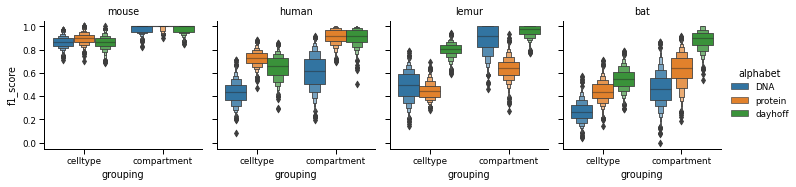

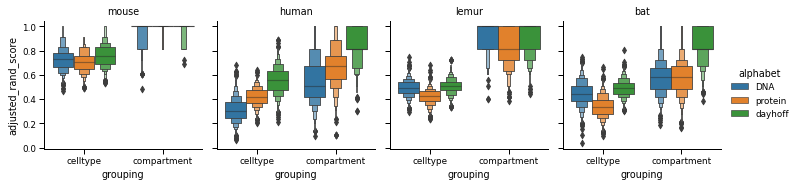

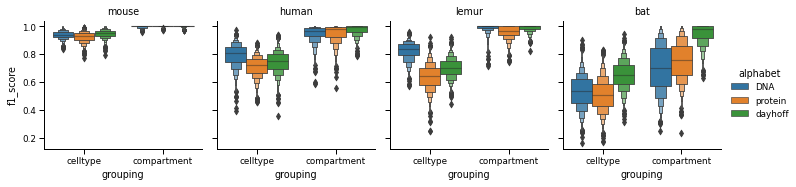

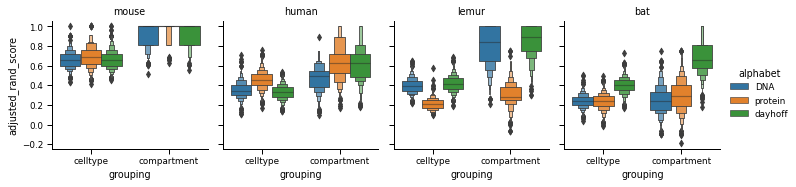

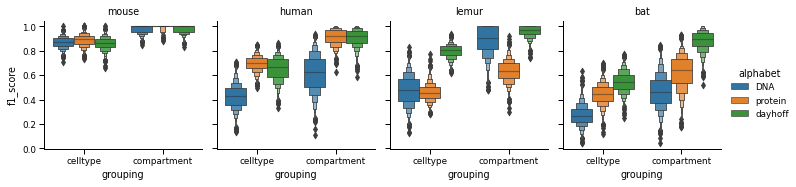

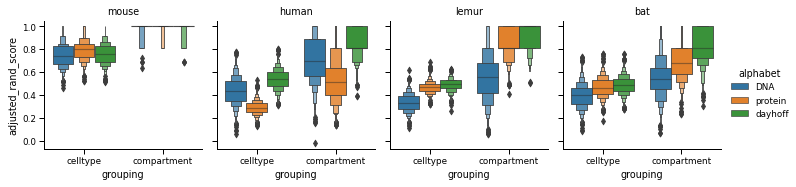

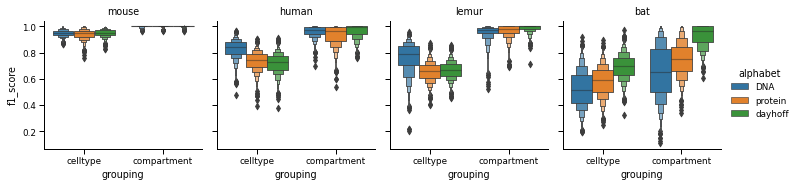

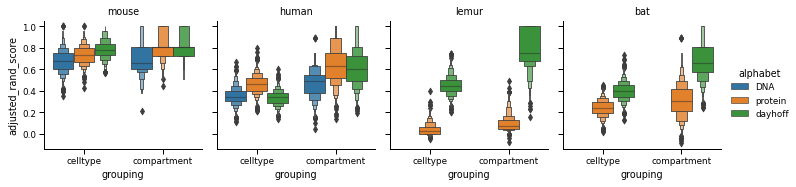

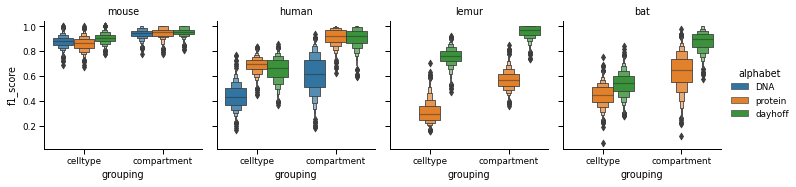

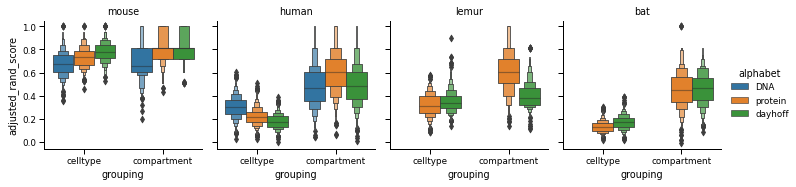

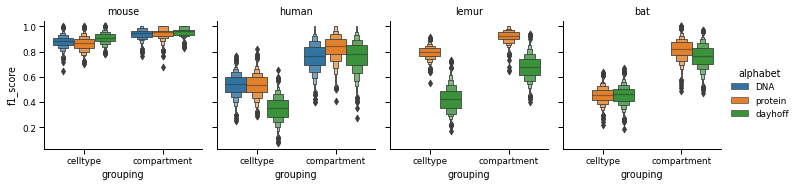

In [175]:
for database_type, database_df in concatenated_metrics.groupby('database_type'):
    print(f'--- {database_type} ---')

    for score_name, df in database_df.groupby('score_name'):
        g = sns.catplot(
            data=df,
            hue="alphabet",
            x="grouping",
            y="score_value",
            col="species",
    #         row="score_name",
            kind="boxen",
            height=2.5,
            hue_order=alphabet_order,
            col_order=species_order,
            palette="tab10",
        )
        g.set_titles("{col_name}")
        g.set_ylabels(score_name)
        pdf = os.path.join(concatenated_metrics_folder, f"boxenplot_metrics_per_species__hue-alphabet__{database_type}__{score_name}.pdf")
        g.savefig(pdf)

### @paper - barplot of compartment, celltype metrics per alphabet

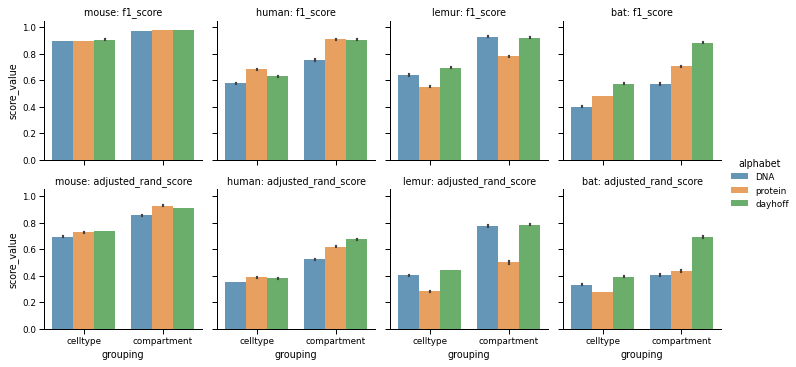

In [176]:
g = sns.catplot(
    data=concatenated_metrics,
    hue="alphabet",
    x="grouping",
    y="score_value",
    col="species",
    row="score_name",
    kind="bar",
    height=2.5,
    order=["celltype", "compartment"],
    hue_order=alphabet_order,
    col_order=species_order,
    palette="tab10",
    alpha=0.75,
)
# g.map(sns.stripplot, "grouping", "score_value", dodge=True, zorder=-1, alpha=0.5)
g.set_titles("{col_name}: {row_name}")

## Transparent axes background
# ylim from stripplot
g.set(facecolor=(0.0, 0.0, 0.0, 0.0), ylim=(0, 1.0506825938566553))
pdf = os.path.join(
    concatenated_metrics_folder,
    "barplot_metrics_per_species__hue-alphabet__stripplot.pdf",
)
g.savefig(pdf, transparent=True)

### @paper - stripplot of compartment, celltype metrics per alphabet

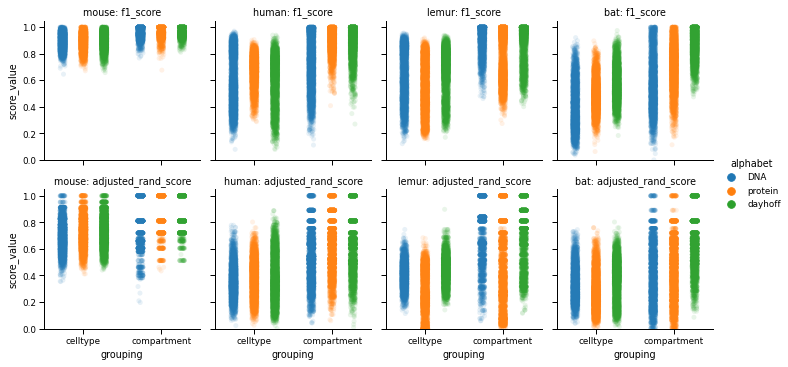

In [177]:
g = sns.catplot(
    data=concatenated_metrics,
    hue="alphabet",
    x="grouping",
    y="score_value",
    col="species",
    row="score_name",
    kind="strip",
    height=2.5,
    hue_order=alphabet_order,
    col_order=species_order,
    palette="tab10",
    alpha=0.1,
    dodge=True,
)
# g._colors = sns.palettes._ColorPalette(
#     [
#         (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
#         (1.0, 0.4980392156862745, 0.054901960784313725),
#         (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
#     ]
# )
# g._hue_var = "alphabet"
# g.hue_names = alphabet_order
# g.map(sns.barplot, "grouping", "score_value", zorder=-1, alpha=0.5)


## Transparent axes background
# ylim from stripplot and barplot
g.set(facecolor=(0.0, 0.0, 0.0, 0.0), ylim=(0, 1.0506825938566553))

g.set_titles("{col_name}: {row_name}")
pdf = os.path.join(
    concatenated_metrics_folder,
    "stripplot_metrics_per_species__hue-alphabet.pdf",
)
g.savefig(pdf, transparent=True)

In [178]:
g.hue_kws

{}